### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor

In [5]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    if(random.random() < p):
        jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
        image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Gland_Dataset("../gland_data/crop_benq_train.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Gland_Dataset("../gland_data/crop_benq_test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask = next(iter(test_dataloader))

In [6]:
image.shape

torch.Size([59, 1, 128, 128])

In [7]:
print(len(train_dataset), len(test_dataset))

154 79


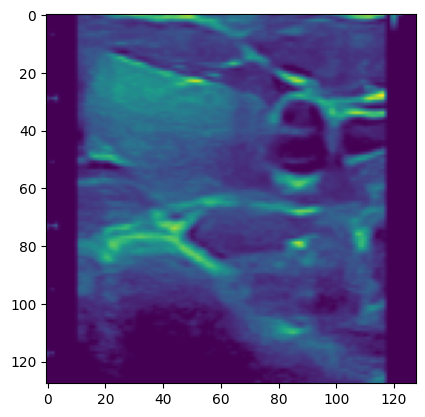

In [8]:
plt.imshow(image[18][0])

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()
        count+=1
        # if count==5:
        #     break
    return total_loss/count, total_IOU/count, total_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    
    total_IOU = 0
    
    total_DICE = 0

    model.eval()
    model.to(device)
    conut = 0
    for image, mask in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        
        output = outputs[:, 0:1, :, :]
        
        
        loss = loss_fn(output, mask)

        IOU = IOU_score(output, mask)

        dice_loss = DiceLoss()
        DICE = 1 - dice_loss(output, mask)
    

        total_loss += loss.item()
        
        total_IOU += IOU.item()
        
        total_DICE += DICE.item()
        conut += 1
    return total_loss/conut, total_IOU/conut, total_DICE/conut


    

In [10]:

inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [11]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [12]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [13]:

project = "thyroid_gland_finetune"
name = "hybrid_model_gland_baseline(1)_freeze_encoder_wo_zeromask_aug_colorjitter_affine_crop"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

In [14]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [15]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/gland/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/gland/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/gland/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


train loss : 1.7429317235946655, train IOU : 0.22141340374946594, train DICE : 0.41514793038368225


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


val loss : 1.6509958505630493, val IOU : 0.0467427521944046, val DICE : 0.13598251342773438
epoch : 1


100%|██████████| 2/2 [00:01<00:00,  1.42it/s]


train loss : 1.3705862164497375, train IOU : 0.306512251496315, train DICE : 0.4852372407913208


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 1.3238049745559692, val IOU : 0.11475025862455368, val DICE : 0.28254175186157227
epoch : 2


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.9823222756385803, train IOU : 0.45748327672481537, train DICE : 0.6114086806774139


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.991414487361908, val IOU : 0.3076424300670624, val DICE : 0.4902297854423523
epoch : 3


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.7386596500873566, train IOU : 0.6047827005386353, train DICE : 0.698024570941925


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.7869929671287537, val IOU : 0.4816102385520935, val DICE : 0.6176313161849976
epoch : 4


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.6805367469787598, train IOU : 0.6256219744682312, train DICE : 0.7140124440193176


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.681147038936615, val IOU : 0.5653928518295288, val DICE : 0.6755977869033813
epoch : 5


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.6426419913768768, train IOU : 0.6511989831924438, train DICE : 0.7364571392536163


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.6353341937065125, val IOU : 0.5915631651878357, val DICE : 0.6987252235412598
epoch : 6


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.6450280249118805, train IOU : 0.6418117880821228, train DICE : 0.7320501208305359


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.6078039407730103, val IOU : 0.6067150831222534, val DICE : 0.7108742594718933
epoch : 7


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.6390115022659302, train IOU : 0.6446249485015869, train DICE : 0.7336780428886414


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.586667537689209, val IOU : 0.6207181811332703, val DICE : 0.7203331589698792
epoch : 8


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.5989284217357635, train IOU : 0.6571430265903473, train DICE : 0.7347392141819


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.5698756575584412, val IOU : 0.633754551410675, val DICE : 0.7282965183258057
epoch : 9


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.5824847519397736, train IOU : 0.6727508306503296, train DICE : 0.7513231635093689


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.5603827834129333, val IOU : 0.6409350633621216, val DICE : 0.7332133650779724
epoch : 10


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.5809993743896484, train IOU : 0.7019559741020203, train DICE : 0.7726911306381226


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.5532504320144653, val IOU : 0.6454862356185913, val DICE : 0.7365269064903259
epoch : 11


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.5532130002975464, train IOU : 0.7096920013427734, train DICE : 0.7793165445327759


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.5490742325782776, val IOU : 0.6481893062591553, val DICE : 0.7375762462615967
epoch : 12


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.540459394454956, train IOU : 0.7050636112689972, train DICE : 0.7815944254398346


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.5457876324653625, val IOU : 0.648162305355072, val DICE : 0.7366756200790405
epoch : 13


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.5300552546977997, train IOU : 0.7193704545497894, train DICE : 0.7882820963859558


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.5447226166725159, val IOU : 0.6476816534996033, val DICE : 0.7352313995361328
epoch : 14


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.5423780679702759, train IOU : 0.7023251950740814, train DICE : 0.7802113890647888


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.5455998182296753, val IOU : 0.6456642746925354, val DICE : 0.7326474189758301
epoch : 15


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.5047722160816193, train IOU : 0.7079147398471832, train DICE : 0.7789438664913177


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5470665097236633, val IOU : 0.6432912945747375, val DICE : 0.7294747233390808
epoch : 16


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.4942104071378708, train IOU : 0.7405080199241638, train DICE : 0.7978046536445618


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.5507481098175049, val IOU : 0.6396735310554504, val DICE : 0.7252109050750732
epoch : 17


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.48497919738292694, train IOU : 0.7394828498363495, train DICE : 0.8022115528583527


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5529714226722717, val IOU : 0.6361708045005798, val DICE : 0.7223629355430603
epoch : 18


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.502145990729332, train IOU : 0.7376530766487122, train DICE : 0.7964441776275635


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5544256567955017, val IOU : 0.6337926983833313, val DICE : 0.7204182147979736
epoch : 19


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.47411970794200897, train IOU : 0.7499506175518036, train DICE : 0.8082091510295868


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.5525668263435364, val IOU : 0.6341780424118042, val DICE : 0.7210298776626587
epoch : 20


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.4715181738138199, train IOU : 0.7345042824745178, train DICE : 0.8022606670856476


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.5483518242835999, val IOU : 0.6373255252838135, val DICE : 0.7230373024940491
epoch : 21


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.47468647360801697, train IOU : 0.739584356546402, train DICE : 0.8008619248867035


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5440664887428284, val IOU : 0.6400200724601746, val DICE : 0.7251100540161133
epoch : 22


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.4724939167499542, train IOU : 0.746566891670227, train DICE : 0.8060446679592133


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.5392948389053345, val IOU : 0.643647313117981, val DICE : 0.7268567681312561
epoch : 23


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.4297279864549637, train IOU : 0.7642020881175995, train DICE : 0.8200052082538605


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.5362147688865662, val IOU : 0.6472416520118713, val DICE : 0.728666365146637
epoch : 24


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.4554530531167984, train IOU : 0.7719981968402863, train DICE : 0.8208544552326202


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.5287407636642456, val IOU : 0.6526960730552673, val DICE : 0.7331918478012085
epoch : 25


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.41713088750839233, train IOU : 0.7830137610435486, train DICE : 0.834600418806076


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5242867469787598, val IOU : 0.6549385190010071, val DICE : 0.7354157567024231
epoch : 26


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.4311404526233673, train IOU : 0.7684270441532135, train DICE : 0.8257607817649841


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.5205193758010864, val IOU : 0.6588326096534729, val DICE : 0.7381181716918945
epoch : 27


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.43798595666885376, train IOU : 0.7750240862369537, train DICE : 0.8340669274330139


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.5164397954940796, val IOU : 0.6627657413482666, val DICE : 0.7417039275169373
epoch : 28


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.43475884199142456, train IOU : 0.7729939222335815, train DICE : 0.8334516882896423


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.5128142237663269, val IOU : 0.6654286980628967, val DICE : 0.7453591823577881
epoch : 29


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.45499733090400696, train IOU : 0.7704009115695953, train DICE : 0.8312263786792755


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.5101088881492615, val IOU : 0.6676579117774963, val DICE : 0.7474292516708374
epoch : 30


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.4205097407102585, train IOU : 0.7756683230400085, train DICE : 0.8320505619049072


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5116626024246216, val IOU : 0.6683363914489746, val DICE : 0.7477232217788696
epoch : 31


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.41900983452796936, train IOU : 0.7750044465065002, train DICE : 0.8340159952640533


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.5090615153312683, val IOU : 0.6709795594215393, val DICE : 0.7491942644119263
epoch : 32


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.4070613980293274, train IOU : 0.79075026512146, train DICE : 0.8441162705421448


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.5035043954849243, val IOU : 0.6741204857826233, val DICE : 0.7517073750495911
epoch : 33


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.3968450129032135, train IOU : 0.7825208306312561, train DICE : 0.8376155197620392


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.500685453414917, val IOU : 0.6749392747879028, val DICE : 0.7513741850852966
epoch : 34


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.39776091277599335, train IOU : 0.7958223819732666, train DICE : 0.8458146750926971


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.49627938866615295, val IOU : 0.678180992603302, val DICE : 0.752714991569519
epoch : 35


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.40541014075279236, train IOU : 0.779747724533081, train DICE : 0.8364990949630737


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.49011364579200745, val IOU : 0.6832153797149658, val DICE : 0.7564560174942017
epoch : 36


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.39710456132888794, train IOU : 0.7818377017974854, train DICE : 0.8411799371242523


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.48476913571357727, val IOU : 0.6886405348777771, val DICE : 0.7601640820503235
epoch : 37


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3818652033805847, train IOU : 0.8026976585388184, train DICE : 0.8544950485229492


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4839182198047638, val IOU : 0.6897603273391724, val DICE : 0.7608248591423035
epoch : 38


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.38279809057712555, train IOU : 0.8035650253295898, train DICE : 0.8531326949596405


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.48792338371276855, val IOU : 0.6847389340400696, val DICE : 0.7583892345428467
epoch : 39


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.37370365858078003, train IOU : 0.8144631385803223, train DICE : 0.8603232204914093


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.48947402834892273, val IOU : 0.6820493936538696, val DICE : 0.7591902613639832
epoch : 40


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.35870662331581116, train IOU : 0.8162325322628021, train DICE : 0.8658681213855743


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.48954641819000244, val IOU : 0.6828048229217529, val DICE : 0.7615820169448853
epoch : 41


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3636264055967331, train IOU : 0.8087427914142609, train DICE : 0.8620744049549103


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.486308217048645, val IOU : 0.6864829063415527, val DICE : 0.7661329507827759
epoch : 42


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.36006972193717957, train IOU : 0.8016957640647888, train DICE : 0.8618143200874329


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4816511273384094, val IOU : 0.6900789141654968, val DICE : 0.7691728472709656
epoch : 43


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3948430269956589, train IOU : 0.7853987514972687, train DICE : 0.8500509858131409


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.47482025623321533, val IOU : 0.6951859593391418, val DICE : 0.7720575928688049
epoch : 44


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.35859088599681854, train IOU : 0.7985265851020813, train DICE : 0.8571450710296631


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.47324204444885254, val IOU : 0.6968065500259399, val DICE : 0.7715666890144348
epoch : 45


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.3260553628206253, train IOU : 0.830558180809021, train DICE : 0.8737456500530243


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.46905750036239624, val IOU : 0.7018479108810425, val DICE : 0.7753304839134216
epoch : 46


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.31368792057037354, train IOU : 0.8379267454147339, train DICE : 0.8826474547386169


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.46310755610466003, val IOU : 0.7069014310836792, val DICE : 0.7810283899307251
epoch : 47


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3430754691362381, train IOU : 0.8204500377178192, train DICE : 0.872433066368103


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4625777006149292, val IOU : 0.7060950398445129, val DICE : 0.7825931310653687
epoch : 48


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.369754895567894, train IOU : 0.8097297549247742, train DICE : 0.8694134056568146


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4630123972892761, val IOU : 0.7034438848495483, val DICE : 0.7823329567909241
epoch : 49


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.34682147204875946, train IOU : 0.8264552652835846, train DICE : 0.874776154756546


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.46603405475616455, val IOU : 0.6989349722862244, val DICE : 0.7798377871513367
epoch : 50


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.33520571887493134, train IOU : 0.8126662373542786, train DICE : 0.8678201138973236


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.46476316452026367, val IOU : 0.7002291083335876, val DICE : 0.7797620296478271
epoch : 51


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.34290966391563416, train IOU : 0.8057791292667389, train DICE : 0.8611922562122345


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.45590314269065857, val IOU : 0.7101858258247375, val DICE : 0.7857853174209595
epoch : 52


100%|██████████| 2/2 [00:01<00:00,  1.45it/s]


train loss : 0.34716078639030457, train IOU : 0.8188838958740234, train DICE : 0.8662897944450378


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.44702163338661194, val IOU : 0.720306396484375, val DICE : 0.7946217656135559
epoch : 53


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3272036164999008, train IOU : 0.8364626169204712, train DICE : 0.8819712102413177


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.44228893518447876, val IOU : 0.7226598858833313, val DICE : 0.7984662652015686
epoch : 54


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3395790159702301, train IOU : 0.8204069137573242, train DICE : 0.8776715397834778


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4416188895702362, val IOU : 0.7194712162017822, val DICE : 0.7960387468338013
epoch : 55


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.32408829033374786, train IOU : 0.8374951481819153, train DICE : 0.8849363029003143


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4480877220630646, val IOU : 0.7103809714317322, val DICE : 0.7892820239067078
epoch : 56


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.32469163835048676, train IOU : 0.8251741230487823, train DICE : 0.8747192025184631


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4535525143146515, val IOU : 0.7066045999526978, val DICE : 0.7861069440841675
epoch : 57


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.32005536556243896, train IOU : 0.8319295644760132, train DICE : 0.8803223967552185


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4529319107532501, val IOU : 0.7126051783561707, val DICE : 0.7900596261024475
epoch : 58


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.31737786531448364, train IOU : 0.8412615656852722, train DICE : 0.8864475786685944


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4527764916419983, val IOU : 0.716350257396698, val DICE : 0.7940493822097778
epoch : 59


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.32525119185447693, train IOU : 0.822694331407547, train DICE : 0.8793655931949615


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.44967642426490784, val IOU : 0.7163051962852478, val DICE : 0.7944586277008057
epoch : 60


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.3109722286462784, train IOU : 0.8444966673851013, train DICE : 0.8890639841556549


100%|██████████| 1/1 [00:00<00:00,  1.48it/s]


val loss : 0.44698914885520935, val IOU : 0.7137686610221863, val DICE : 0.7931511998176575
epoch : 61


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.3378179669380188, train IOU : 0.8268935680389404, train DICE : 0.873769998550415


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.44110724329948425, val IOU : 0.7171933650970459, val DICE : 0.7970792651176453
epoch : 62


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.3187474310398102, train IOU : 0.8247448801994324, train DICE : 0.875432014465332


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4359598457813263, val IOU : 0.7240056395530701, val DICE : 0.803733229637146
epoch : 63


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3075518310070038, train IOU : 0.8369003534317017, train DICE : 0.8891052305698395


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43455421924591064, val IOU : 0.7279028296470642, val DICE : 0.806727945804596
epoch : 64


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.3287365436553955, train IOU : 0.82306307554245, train DICE : 0.8775562644004822


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.43349912762641907, val IOU : 0.7298793196678162, val DICE : 0.8072649240493774
epoch : 65


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.3022734075784683, train IOU : 0.845048189163208, train DICE : 0.8924344480037689


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4317825138568878, val IOU : 0.7304373383522034, val DICE : 0.8061215281486511
epoch : 66


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3049647659063339, train IOU : 0.8378129005432129, train DICE : 0.8888033330440521


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4307067394256592, val IOU : 0.7267263531684875, val DICE : 0.8026447892189026
epoch : 67


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3130148947238922, train IOU : 0.8298249244689941, train DICE : 0.8844384551048279


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4310778081417084, val IOU : 0.7229855060577393, val DICE : 0.8013710975646973
epoch : 68


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.30324873328208923, train IOU : 0.8447217643260956, train DICE : 0.8914158046245575


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4313640296459198, val IOU : 0.7238434553146362, val DICE : 0.8026992082595825
epoch : 69


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3192468285560608, train IOU : 0.8405357301235199, train DICE : 0.8836430013179779


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43402716517448425, val IOU : 0.7254597544670105, val DICE : 0.805070161819458
epoch : 70


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3161008805036545, train IOU : 0.8308219611644745, train DICE : 0.8883562386035919


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43374335765838623, val IOU : 0.7293344140052795, val DICE : 0.808009147644043
epoch : 71


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.3006872534751892, train IOU : 0.8349686563014984, train DICE : 0.8896593451499939


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.43591633439064026, val IOU : 0.7270545363426208, val DICE : 0.804139256477356
epoch : 72


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3076438903808594, train IOU : 0.8437824845314026, train DICE : 0.8910810351371765


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.44180721044540405, val IOU : 0.7203203439712524, val DICE : 0.7971099615097046
epoch : 73


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3486326187849045, train IOU : 0.8242086470127106, train DICE : 0.8772577345371246


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4344107210636139, val IOU : 0.724928081035614, val DICE : 0.8027610182762146
epoch : 74


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2988668233156204, train IOU : 0.8461728990077972, train DICE : 0.8921439349651337


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4305685758590698, val IOU : 0.7328806519508362, val DICE : 0.809978187084198
epoch : 75


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.31672245264053345, train IOU : 0.829937607049942, train DICE : 0.8865107893943787


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4328609108924866, val IOU : 0.7325946092605591, val DICE : 0.8104832172393799
epoch : 76


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2946997880935669, train IOU : 0.851340651512146, train DICE : 0.9000195562839508


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4387604594230652, val IOU : 0.724802553653717, val DICE : 0.8044816255569458
epoch : 77


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.29009412229061127, train IOU : 0.8535116314888, train DICE : 0.8991353809833527


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4470653533935547, val IOU : 0.7119317650794983, val DICE : 0.7938865423202515
epoch : 78


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2952803671360016, train IOU : 0.8479268252849579, train DICE : 0.8956080079078674


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.44507041573524475, val IOU : 0.7087680101394653, val DICE : 0.7920190095901489
epoch : 79


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.2673039734363556, train IOU : 0.8641966283321381, train DICE : 0.9053089320659637


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4427001178264618, val IOU : 0.7128720283508301, val DICE : 0.7949930429458618
epoch : 80


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.31120966374874115, train IOU : 0.8352890312671661, train DICE : 0.8918343484401703


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.433971107006073, val IOU : 0.7209574580192566, val DICE : 0.8028731942176819
epoch : 81


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.29938043653964996, train IOU : 0.8419403731822968, train DICE : 0.8927930593490601


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4275054931640625, val IOU : 0.7262579798698425, val DICE : 0.8082703351974487
epoch : 82


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2882467806339264, train IOU : 0.8425445556640625, train DICE : 0.8921276926994324


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42770490050315857, val IOU : 0.7320400476455688, val DICE : 0.8121820092201233
epoch : 83


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2970859855413437, train IOU : 0.8487325310707092, train DICE : 0.8920577168464661


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43069466948509216, val IOU : 0.736450731754303, val DICE : 0.8165944814682007
epoch : 84


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.3059761971235275, train IOU : 0.8456593453884125, train DICE : 0.8926827609539032


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4337402880191803, val IOU : 0.7383357286453247, val DICE : 0.8178720474243164
epoch : 85


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.3022352457046509, train IOU : 0.8409505188465118, train DICE : 0.8940978944301605


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4282195568084717, val IOU : 0.7380927205085754, val DICE : 0.8175662755966187
epoch : 86


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2766246795654297, train IOU : 0.8577857613563538, train DICE : 0.9045330286026001


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4261307120323181, val IOU : 0.728794276714325, val DICE : 0.8110576272010803
epoch : 87


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.30679264664649963, train IOU : 0.8432106375694275, train DICE : 0.8931826055049896


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4308570921421051, val IOU : 0.719061017036438, val DICE : 0.801950991153717
epoch : 88


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.28215034306049347, train IOU : 0.8592000901699066, train DICE : 0.9021219611167908


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4306093752384186, val IOU : 0.7197361588478088, val DICE : 0.8020484447479248
epoch : 89


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2985409200191498, train IOU : 0.8480456471443176, train DICE : 0.8975953757762909


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4300394356250763, val IOU : 0.7247889041900635, val DICE : 0.8061540126800537
epoch : 90


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27940599620342255, train IOU : 0.8565641045570374, train DICE : 0.9045557379722595


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43104737997055054, val IOU : 0.7272907495498657, val DICE : 0.808163046836853
epoch : 91


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.28109852969646454, train IOU : 0.8569534420967102, train DICE : 0.9017605781555176


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4329700171947479, val IOU : 0.7287636399269104, val DICE : 0.8073151707649231
epoch : 92


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.28723083436489105, train IOU : 0.8436612784862518, train DICE : 0.8912871479988098


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4439663887023926, val IOU : 0.7209557890892029, val DICE : 0.8012191653251648
epoch : 93


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2947166860103607, train IOU : 0.8547516763210297, train DICE : 0.895913153886795


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4455384612083435, val IOU : 0.719835102558136, val DICE : 0.8011191487312317
epoch : 94


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.28713665902614594, train IOU : 0.8454330861568451, train DICE : 0.891377717256546


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43058472871780396, val IOU : 0.7315752506256104, val DICE : 0.8104079961776733
epoch : 95


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27310702204704285, train IOU : 0.8642652630805969, train DICE : 0.9067212641239166


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4261249601840973, val IOU : 0.7348248958587646, val DICE : 0.8131495714187622
epoch : 96


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.32407906651496887, train IOU : 0.8230398595333099, train DICE : 0.8811237514019012


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42314329743385315, val IOU : 0.7354031801223755, val DICE : 0.8116011023521423
epoch : 97


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.29386892914772034, train IOU : 0.8553988039493561, train DICE : 0.898811548948288


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4226524233818054, val IOU : 0.7340589761734009, val DICE : 0.8097070455551147
epoch : 98


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27311308681964874, train IOU : 0.858711302280426, train DICE : 0.8991062045097351


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4209832549095154, val IOU : 0.7352114319801331, val DICE : 0.8118506669998169
epoch : 99


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.28942766785621643, train IOU : 0.8454712927341461, train DICE : 0.8982048630714417


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4215804636478424, val IOU : 0.7358999848365784, val DICE : 0.8144327998161316
epoch : 100


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.26464055478572845, train IOU : 0.8669692277908325, train DICE : 0.9093925654888153


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42006710171699524, val IOU : 0.7377051115036011, val DICE : 0.8165820240974426
epoch : 101


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.27108074724674225, train IOU : 0.8601613938808441, train DICE : 0.9045873880386353


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.41923364996910095, val IOU : 0.7367998361587524, val DICE : 0.8162177205085754
epoch : 102


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2873344421386719, train IOU : 0.8506172001361847, train DICE : 0.902072548866272


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4218808114528656, val IOU : 0.7313231229782104, val DICE : 0.8130680918693542
epoch : 103


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.29710695147514343, train IOU : 0.8546644747257233, train DICE : 0.8990646302700043


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4248848259449005, val IOU : 0.7302794456481934, val DICE : 0.8127716779708862
epoch : 104


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.277840331196785, train IOU : 0.8531045913696289, train DICE : 0.9037278890609741


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42643415927886963, val IOU : 0.7317726016044617, val DICE : 0.8141531944274902
epoch : 105


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27970485389232635, train IOU : 0.8497252762317657, train DICE : 0.8965097665786743


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4276902377605438, val IOU : 0.7319721579551697, val DICE : 0.8133940696716309
epoch : 106


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2535090148448944, train IOU : 0.8686843514442444, train DICE : 0.9093474447727203


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42962658405303955, val IOU : 0.7325230240821838, val DICE : 0.8127471804618835
epoch : 107


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.29644665122032166, train IOU : 0.8511797189712524, train DICE : 0.8946585357189178


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4220111668109894, val IOU : 0.7395069599151611, val DICE : 0.8176306486129761
epoch : 108


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.27589020133018494, train IOU : 0.8606149554252625, train DICE : 0.9029059112071991


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4169446527957916, val IOU : 0.7418515682220459, val DICE : 0.8201355338096619
epoch : 109


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2632475048303604, train IOU : 0.8603646457195282, train DICE : 0.9073556661605835


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4161466956138611, val IOU : 0.7409140467643738, val DICE : 0.8201192617416382
epoch : 110


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2810080945491791, train IOU : 0.8513790369033813, train DICE : 0.9035198092460632


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42267531156539917, val IOU : 0.7327088713645935, val DICE : 0.8138211965560913
epoch : 111


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27668769657611847, train IOU : 0.8551548421382904, train DICE : 0.8967894911766052


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43153873085975647, val IOU : 0.7238918542861938, val DICE : 0.8057456612586975
epoch : 112


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27932479977607727, train IOU : 0.8610038459300995, train DICE : 0.9060351252555847


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4346274733543396, val IOU : 0.7230587601661682, val DICE : 0.8052974939346313
epoch : 113


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.25532835721969604, train IOU : 0.8691010475158691, train DICE : 0.9119087755680084


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43448472023010254, val IOU : 0.7277330160140991, val DICE : 0.8091179132461548
epoch : 114


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2821243852376938, train IOU : 0.8633106648921967, train DICE : 0.9053145945072174


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42907583713531494, val IOU : 0.7335509657859802, val DICE : 0.815545380115509
epoch : 115


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2669840455055237, train IOU : 0.8592469096183777, train DICE : 0.9039944410324097


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42376387119293213, val IOU : 0.7354834675788879, val DICE : 0.8178487420082092
epoch : 116


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2858891487121582, train IOU : 0.8578473925590515, train DICE : 0.9029554724693298


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4293389320373535, val IOU : 0.7294139266014099, val DICE : 0.8118239641189575
epoch : 117


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.24971482902765274, train IOU : 0.8756149709224701, train DICE : 0.9120419323444366


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4386847913265228, val IOU : 0.7223148941993713, val DICE : 0.8054640293121338
epoch : 118


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.28518742322921753, train IOU : 0.8521029949188232, train DICE : 0.8999690115451813


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.43424105644226074, val IOU : 0.7264898419380188, val DICE : 0.8090378642082214
epoch : 119


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2687077820301056, train IOU : 0.8667541444301605, train DICE : 0.9099704921245575


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43384894728660583, val IOU : 0.7254337668418884, val DICE : 0.8101988434791565
epoch : 120


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.26601742208004, train IOU : 0.8630087971687317, train DICE : 0.9055327773094177


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43143782019615173, val IOU : 0.7271568775177002, val DICE : 0.8119652271270752
epoch : 121


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2752951383590698, train IOU : 0.8486713469028473, train DICE : 0.8989072740077972


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4319228529930115, val IOU : 0.7280587553977966, val DICE : 0.8108574151992798
epoch : 122


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2572464048862457, train IOU : 0.8708100914955139, train DICE : 0.9084320962429047


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.435566782951355, val IOU : 0.7282751798629761, val DICE : 0.8089480996131897
epoch : 123


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.26335282623767853, train IOU : 0.87081179022789, train DICE : 0.9117753505706787


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.432125985622406, val IOU : 0.734574019908905, val DICE : 0.8140910267829895
epoch : 124


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24782522022724152, train IOU : 0.8812945485115051, train DICE : 0.9157089293003082


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4273587167263031, val IOU : 0.7387753129005432, val DICE : 0.8192375302314758
epoch : 125


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2880348712205887, train IOU : 0.8480580449104309, train DICE : 0.8992599248886108


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4212149381637573, val IOU : 0.7372915148735046, val DICE : 0.819006085395813
epoch : 126


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2602664679288864, train IOU : 0.8689108788967133, train DICE : 0.9126544892787933


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41947054862976074, val IOU : 0.7292054295539856, val DICE : 0.8124779462814331
epoch : 127


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.26413651555776596, train IOU : 0.8609445095062256, train DICE : 0.9054465889930725


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4268473982810974, val IOU : 0.7205994725227356, val DICE : 0.8043590188026428
epoch : 128


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.26260997354984283, train IOU : 0.8696315586566925, train DICE : 0.9081310927867889


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.4226997494697571, val IOU : 0.7306658029556274, val DICE : 0.8103496432304382
epoch : 129


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2488304004073143, train IOU : 0.875655859708786, train DICE : 0.9147047400474548


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.425176203250885, val IOU : 0.7376279830932617, val DICE : 0.8175979256629944
epoch : 130


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2650219574570656, train IOU : 0.8618888556957245, train DICE : 0.9085139632225037


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42955243587493896, val IOU : 0.7368471622467041, val DICE : 0.8190036416053772
epoch : 131


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2596520185470581, train IOU : 0.8732506632804871, train DICE : 0.9140676558017731


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4311186373233795, val IOU : 0.731613278388977, val DICE : 0.8159815669059753
epoch : 132


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.25121190398931503, train IOU : 0.8753051161766052, train DICE : 0.9157977402210236


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43369951844215393, val IOU : 0.7236226797103882, val DICE : 0.8093240261077881
epoch : 133


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2742779850959778, train IOU : 0.8642232716083527, train DICE : 0.9079144299030304


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43367716670036316, val IOU : 0.7213867902755737, val DICE : 0.8074172139167786
epoch : 134


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2630382180213928, train IOU : 0.870999664068222, train DICE : 0.9111044108867645


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4256235957145691, val IOU : 0.7301415801048279, val DICE : 0.8146638870239258
epoch : 135


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24219587445259094, train IOU : 0.877778947353363, train DICE : 0.9168791472911835


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42107224464416504, val IOU : 0.7369935512542725, val DICE : 0.8200763463973999
epoch : 136


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2395172417163849, train IOU : 0.8777398467063904, train DICE : 0.9178323447704315


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4193039536476135, val IOU : 0.7386876940727234, val DICE : 0.8212130665779114
epoch : 137


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2696927338838577, train IOU : 0.8591658473014832, train DICE : 0.9058895409107208


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41835448145866394, val IOU : 0.7353796362876892, val DICE : 0.8180939555168152
epoch : 138


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2728933244943619, train IOU : 0.8713044226169586, train DICE : 0.9141684174537659


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4238220453262329, val IOU : 0.7248702049255371, val DICE : 0.8095308542251587
epoch : 139


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.259907990694046, train IOU : 0.8731779456138611, train DICE : 0.9130137860774994


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4297688901424408, val IOU : 0.7187207341194153, val DICE : 0.8063234686851501
epoch : 140


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.26333028078079224, train IOU : 0.8643321096897125, train DICE : 0.909443199634552


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4277377426624298, val IOU : 0.7229956984519958, val DICE : 0.8089956045150757
epoch : 141


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.257277250289917, train IOU : 0.8717508316040039, train DICE : 0.9136691689491272


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4296954870223999, val IOU : 0.7244545817375183, val DICE : 0.8095569014549255
epoch : 142


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27152352035045624, train IOU : 0.8588698506355286, train DICE : 0.9045997262001038


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4318135678768158, val IOU : 0.7255212664604187, val DICE : 0.809909462928772
epoch : 143


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2608392983675003, train IOU : 0.8668977618217468, train DICE : 0.9083743393421173


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43452808260917664, val IOU : 0.7281306385993958, val DICE : 0.8110613822937012
epoch : 144


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.25058990716934204, train IOU : 0.8743945956230164, train DICE : 0.9132114946842194


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4326944947242737, val IOU : 0.7344533205032349, val DICE : 0.8175720572471619
epoch : 145


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2501114383339882, train IOU : 0.8636207580566406, train DICE : 0.9114281535148621


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4353408217430115, val IOU : 0.7352058291435242, val DICE : 0.8187283277511597
epoch : 146


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.26176318526268005, train IOU : 0.8728657364845276, train DICE : 0.9152955412864685


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43266332149505615, val IOU : 0.7360436320304871, val DICE : 0.8188226222991943
epoch : 147


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.27749739587306976, train IOU : 0.8684192299842834, train DICE : 0.910496860742569


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4224018156528473, val IOU : 0.7353528738021851, val DICE : 0.8200473189353943
epoch : 148


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.25041235983371735, train IOU : 0.8715672194957733, train DICE : 0.9153487384319305


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42071792483329773, val IOU : 0.728766679763794, val DICE : 0.8160535097122192
epoch : 149


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.26392462104558945, train IOU : 0.8670622706413269, train DICE : 0.9100265502929688


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4191816747188568, val IOU : 0.7291017174720764, val DICE : 0.8159641027450562
epoch : 150


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.25037917494773865, train IOU : 0.8732514679431915, train DICE : 0.9147678017616272


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4249071776866913, val IOU : 0.7328545451164246, val DICE : 0.8171615600585938
epoch : 151


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.25219208002090454, train IOU : 0.8679374754428864, train DICE : 0.913039356470108


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43700939416885376, val IOU : 0.7336098551750183, val DICE : 0.8169311285018921
epoch : 152


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2786823511123657, train IOU : 0.8491047322750092, train DICE : 0.9033960402011871


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4414283037185669, val IOU : 0.7291586399078369, val DICE : 0.8126262426376343
epoch : 153


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2582997754216194, train IOU : 0.871659129858017, train DICE : 0.9120219647884369


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43099987506866455, val IOU : 0.7289140820503235, val DICE : 0.8123477101325989
epoch : 154


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


train loss : 0.23833351582288742, train IOU : 0.8769095838069916, train DICE : 0.9159058332443237


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4157058596611023, val IOU : 0.7388717532157898, val DICE : 0.8215746879577637
epoch : 155


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2569187730550766, train IOU : 0.8665718734264374, train DICE : 0.9122649431228638


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4131954312324524, val IOU : 0.7396441102027893, val DICE : 0.8229719400405884
epoch : 156


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2821286916732788, train IOU : 0.8535869717597961, train DICE : 0.9064893424510956


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41668105125427246, val IOU : 0.7348348498344421, val DICE : 0.8185306787490845
epoch : 157


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2339233160018921, train IOU : 0.8777314722537994, train DICE : 0.9194967746734619


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42436519265174866, val IOU : 0.726701557636261, val DICE : 0.8116495609283447
epoch : 158


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2559260055422783, train IOU : 0.8703997731208801, train DICE : 0.916368305683136


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.4262414574623108, val IOU : 0.726507842540741, val DICE : 0.8107065558433533
epoch : 159


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.25564780831336975, train IOU : 0.8631630539894104, train DICE : 0.9088242053985596


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4266605079174042, val IOU : 0.7292661666870117, val DICE : 0.8116258978843689
epoch : 160


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24326645582914352, train IOU : 0.8814680576324463, train DICE : 0.9202210307121277


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.424422949552536, val IOU : 0.7329262495040894, val DICE : 0.8149524927139282
epoch : 161


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2547801062464714, train IOU : 0.8629849553108215, train DICE : 0.9103090465068817


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4228932559490204, val IOU : 0.7341678142547607, val DICE : 0.8164931535720825
epoch : 162


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24344145506620407, train IOU : 0.8685710430145264, train DICE : 0.9177664518356323


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42170366644859314, val IOU : 0.7347235083580017, val DICE : 0.817371129989624
epoch : 163


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23881589621305466, train IOU : 0.8756738007068634, train DICE : 0.9197515249252319


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4240543246269226, val IOU : 0.7345141768455505, val DICE : 0.8175045847892761
epoch : 164


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2649410367012024, train IOU : 0.8576648831367493, train DICE : 0.9027647376060486


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42167800664901733, val IOU : 0.7397772073745728, val DICE : 0.8236352801322937
epoch : 165


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23987385630607605, train IOU : 0.8800475001335144, train DICE : 0.9190935790538788


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.415705144405365, val IOU : 0.7461411356925964, val DICE : 0.8299595713615417
epoch : 166


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23985052853822708, train IOU : 0.8745682835578918, train DICE : 0.9167471826076508


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4202879071235657, val IOU : 0.7431305646896362, val DICE : 0.8276678919792175
epoch : 167


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.24436187744140625, train IOU : 0.8747227191925049, train DICE : 0.9170116186141968


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4282623529434204, val IOU : 0.738098680973053, val DICE : 0.8226842880249023
epoch : 168


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24170607328414917, train IOU : 0.8839131593704224, train DICE : 0.9212726950645447


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4351988136768341, val IOU : 0.7354017496109009, val DICE : 0.8211959004402161
epoch : 169


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24856171756982803, train IOU : 0.8753764927387238, train DICE : 0.9158453047275543


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43085408210754395, val IOU : 0.7369699478149414, val DICE : 0.822677731513977
epoch : 170


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23219073563814163, train IOU : 0.8826347291469574, train DICE : 0.920935332775116


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4215327203273773, val IOU : 0.7384796142578125, val DICE : 0.82275390625
epoch : 171


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23365937918424606, train IOU : 0.8863101005554199, train DICE : 0.9222937822341919


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4181753993034363, val IOU : 0.7368757724761963, val DICE : 0.8206291794776917
epoch : 172


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.23850443959236145, train IOU : 0.8800959587097168, train DICE : 0.9206162989139557


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4156282842159271, val IOU : 0.7379857301712036, val DICE : 0.8211287260055542
epoch : 173


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24994078278541565, train IOU : 0.8769458532333374, train DICE : 0.9180595576763153


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4175127446651459, val IOU : 0.7392451167106628, val DICE : 0.8213449120521545
epoch : 174


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.25345874577760696, train IOU : 0.8759821951389313, train DICE : 0.9184165000915527


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.420357346534729, val IOU : 0.7392385601997375, val DICE : 0.8217179775238037
epoch : 175


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2375176101922989, train IOU : 0.8801652789115906, train DICE : 0.9193544387817383


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42288535833358765, val IOU : 0.7361523509025574, val DICE : 0.819463849067688
epoch : 176


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.22903179377317429, train IOU : 0.8829357624053955, train DICE : 0.9197070300579071


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42818716168403625, val IOU : 0.7278780937194824, val DICE : 0.8138076663017273
epoch : 177


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.24881815910339355, train IOU : 0.8722525835037231, train DICE : 0.9114069938659668


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43146759271621704, val IOU : 0.7255396246910095, val DICE : 0.811348557472229
epoch : 178


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22977688163518906, train IOU : 0.8786425888538361, train DICE : 0.920335441827774


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42787232995033264, val IOU : 0.7296276688575745, val DICE : 0.8146506547927856
epoch : 179


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23202669620513916, train IOU : 0.8836553990840912, train DICE : 0.9235491156578064


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.426569402217865, val IOU : 0.7334450483322144, val DICE : 0.817754328250885
epoch : 180


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23714382946491241, train IOU : 0.8804415464401245, train DICE : 0.9213758409023285


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4261591136455536, val IOU : 0.7351366281509399, val DICE : 0.8193016648292542
epoch : 181


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.25803784281015396, train IOU : 0.8700278997421265, train DICE : 0.9143040776252747


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4272482395172119, val IOU : 0.7341582775115967, val DICE : 0.8193256258964539
epoch : 182


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23905512690544128, train IOU : 0.8795165717601776, train DICE : 0.919237345457077


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4259142577648163, val IOU : 0.7332659363746643, val DICE : 0.8194283246994019
epoch : 183


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2611228972673416, train IOU : 0.8739506900310516, train DICE : 0.9177671670913696


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42686811089515686, val IOU : 0.7290031909942627, val DICE : 0.8175328969955444
epoch : 184


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23096780478954315, train IOU : 0.8831106424331665, train DICE : 0.9240423440933228


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42751166224479675, val IOU : 0.7275383472442627, val DICE : 0.8162009716033936
epoch : 185


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.25019755959510803, train IOU : 0.8713383972644806, train DICE : 0.9180748164653778


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43204089999198914, val IOU : 0.7225980162620544, val DICE : 0.8116071224212646
epoch : 186


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24063192307949066, train IOU : 0.8756586909294128, train DICE : 0.9176775217056274


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.438214510679245, val IOU : 0.7169005274772644, val DICE : 0.8057693839073181
epoch : 187


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22778793424367905, train IOU : 0.8864419162273407, train DICE : 0.9224990904331207


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4389593303203583, val IOU : 0.7174962759017944, val DICE : 0.8050894141197205
epoch : 188


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.24079204350709915, train IOU : 0.8817190825939178, train DICE : 0.9224383234977722


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.43977731466293335, val IOU : 0.7191551327705383, val DICE : 0.8056086301803589
epoch : 189


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24390706419944763, train IOU : 0.8773591816425323, train DICE : 0.9178431332111359


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4330166280269623, val IOU : 0.7267778515815735, val DICE : 0.8134410381317139
epoch : 190


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.23479165881872177, train IOU : 0.8747724294662476, train DICE : 0.9168760180473328


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42670440673828125, val IOU : 0.7352893352508545, val DICE : 0.8203620314598083
epoch : 191


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23323607444763184, train IOU : 0.8821818232536316, train DICE : 0.9232514202594757


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4287402331829071, val IOU : 0.7353461384773254, val DICE : 0.8210598230361938
epoch : 192


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2611338123679161, train IOU : 0.8668542802333832, train DICE : 0.914884090423584


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4262176752090454, val IOU : 0.7345641255378723, val DICE : 0.8194403052330017
epoch : 193


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23377178609371185, train IOU : 0.8809706270694733, train DICE : 0.9188380241394043


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42811185121536255, val IOU : 0.7309709787368774, val DICE : 0.8159077763557434
epoch : 194


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24472855776548386, train IOU : 0.8647958934307098, train DICE : 0.9131910800933838


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4213160276412964, val IOU : 0.7413740158081055, val DICE : 0.8234707713127136
epoch : 195


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22624409198760986, train IOU : 0.8874049186706543, train DICE : 0.9249467849731445


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43345293402671814, val IOU : 0.7395119667053223, val DICE : 0.8237441778182983
epoch : 196


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.23875591903924942, train IOU : 0.881995677947998, train DICE : 0.9207664728164673


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.44217735528945923, val IOU : 0.7331407070159912, val DICE : 0.8194066882133484
epoch : 197


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23795152455568314, train IOU : 0.8823073208332062, train DICE : 0.923288494348526


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42648521065711975, val IOU : 0.7355183959007263, val DICE : 0.8198846578598022
epoch : 198


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23680943250656128, train IOU : 0.8814859688282013, train DICE : 0.9210826456546783


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41627877950668335, val IOU : 0.7338386178016663, val DICE : 0.8191614747047424
epoch : 199


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.24503828585147858, train IOU : 0.8781210482120514, train DICE : 0.9184066355228424


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4135228097438812, val IOU : 0.7357240915298462, val DICE : 0.821433424949646
epoch : 200


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.24889614433050156, train IOU : 0.869879812002182, train DICE : 0.9191040992736816


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4098328649997711, val IOU : 0.7426237463951111, val DICE : 0.8269087076187134
epoch : 201


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2430301159620285, train IOU : 0.8776602745056152, train DICE : 0.9209364354610443


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4137592613697052, val IOU : 0.744516909122467, val DICE : 0.8275734186172485
epoch : 202


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2484610304236412, train IOU : 0.8795424103736877, train DICE : 0.9197582006454468


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4210273027420044, val IOU : 0.7411021590232849, val DICE : 0.8247432708740234
epoch : 203


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2355012148618698, train IOU : 0.8851984739303589, train DICE : 0.9231975078582764


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4266057312488556, val IOU : 0.7362985014915466, val DICE : 0.8210811018943787
epoch : 204


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2224171906709671, train IOU : 0.8840625286102295, train DICE : 0.9234103560447693


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42979997396469116, val IOU : 0.7312098145484924, val DICE : 0.8166716694831848
epoch : 205


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2287617027759552, train IOU : 0.8871229588985443, train DICE : 0.9225166440010071


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.43165019154548645, val IOU : 0.7296484708786011, val DICE : 0.815375030040741
epoch : 206


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23186255246400833, train IOU : 0.889846920967102, train DICE : 0.9242774844169617


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.430867999792099, val IOU : 0.7330225706100464, val DICE : 0.8192631006240845
epoch : 207


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.227297343313694, train IOU : 0.8838137984275818, train DICE : 0.9212851822376251


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42918285727500916, val IOU : 0.7350844144821167, val DICE : 0.8219900131225586
epoch : 208


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24076960235834122, train IOU : 0.8778494000434875, train DICE : 0.9204141795635223


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42697224020957947, val IOU : 0.7355443835258484, val DICE : 0.8219669461250305
epoch : 209


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.23692204058170319, train IOU : 0.8823257982730865, train DICE : 0.9201282858848572


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4175284504890442, val IOU : 0.7393718957901001, val DICE : 0.8247146010398865
epoch : 210


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2109060436487198, train IOU : 0.8958670198917389, train DICE : 0.929913341999054


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4090064764022827, val IOU : 0.7470990419387817, val DICE : 0.8285288214683533
epoch : 211


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22536037862300873, train IOU : 0.8861654102802277, train DICE : 0.9246205389499664


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.41025233268737793, val IOU : 0.7488088607788086, val DICE : 0.8285794258117676
epoch : 212


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2265474572777748, train IOU : 0.8823652267456055, train DICE : 0.9220971167087555


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4107806384563446, val IOU : 0.75078284740448, val DICE : 0.8303717374801636
epoch : 213


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.23294910788536072, train IOU : 0.8885947465896606, train DICE : 0.9266622364521027


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4137814939022064, val IOU : 0.7485055923461914, val DICE : 0.8290497660636902
epoch : 214


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24329540133476257, train IOU : 0.8788845539093018, train DICE : 0.9177446365356445


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4073466956615448, val IOU : 0.7470963597297668, val DICE : 0.8281118273735046
epoch : 215


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22455832362174988, train IOU : 0.8892745673656464, train DICE : 0.9261311888694763


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4104192852973938, val IOU : 0.7436466813087463, val DICE : 0.8260935544967651
epoch : 216


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.24164283275604248, train IOU : 0.8805517852306366, train DICE : 0.9225667119026184


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.41984543204307556, val IOU : 0.7382994890213013, val DICE : 0.8221454620361328
epoch : 217


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2337445542216301, train IOU : 0.8717416524887085, train DICE : 0.9157220423221588


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4168091416358948, val IOU : 0.7413496375083923, val DICE : 0.8233417272567749
epoch : 218


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.27113793790340424, train IOU : 0.8555551469326019, train DICE : 0.9094076752662659


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42010167241096497, val IOU : 0.741962730884552, val DICE : 0.8245336413383484
epoch : 219


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.23746375739574432, train IOU : 0.8847403228282928, train DICE : 0.9220195114612579


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4241889715194702, val IOU : 0.7381444573402405, val DICE : 0.8215893507003784
epoch : 220


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22420470416545868, train IOU : 0.8817979991436005, train DICE : 0.9218244552612305


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41986265778541565, val IOU : 0.7384613752365112, val DICE : 0.8210616111755371
epoch : 221


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22195640206336975, train IOU : 0.8893001973628998, train DICE : 0.9262336194515228


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41591182351112366, val IOU : 0.7410691380500793, val DICE : 0.8229866027832031
epoch : 222


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22646750509738922, train IOU : 0.8907823264598846, train DICE : 0.9263631999492645


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.41723188757896423, val IOU : 0.7374247908592224, val DICE : 0.821031928062439
epoch : 223


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22575151920318604, train IOU : 0.8845460414886475, train DICE : 0.9248710870742798


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4227566421031952, val IOU : 0.7312377691268921, val DICE : 0.8166056275367737
epoch : 224


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22532112896442413, train IOU : 0.8906818628311157, train DICE : 0.9268200397491455


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42343613505363464, val IOU : 0.7329652309417725, val DICE : 0.8175792694091797
epoch : 225


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22046662867069244, train IOU : 0.8926217555999756, train DICE : 0.9298788905143738


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42763203382492065, val IOU : 0.7335401773452759, val DICE : 0.8186302185058594
epoch : 226


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.23095888644456863, train IOU : 0.886806070804596, train DICE : 0.9209143817424774


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4264862537384033, val IOU : 0.7362439036369324, val DICE : 0.8219910860061646
epoch : 227


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2263258844614029, train IOU : 0.8907051980495453, train DICE : 0.9277016520500183


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4184805154800415, val IOU : 0.7402908205986023, val DICE : 0.8254958391189575
epoch : 228


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.24673708528280258, train IOU : 0.872281014919281, train DICE : 0.9164994060993195


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41365543007850647, val IOU : 0.7400128841400146, val DICE : 0.8247700929641724
epoch : 229


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22155369073152542, train IOU : 0.8893754184246063, train DICE : 0.9270933866500854


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4126288890838623, val IOU : 0.739797830581665, val DICE : 0.8240540027618408
epoch : 230


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.23161598294973373, train IOU : 0.8830249011516571, train DICE : 0.9211283028125763


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41609618067741394, val IOU : 0.7400258183479309, val DICE : 0.8239488005638123
epoch : 231


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21406852453947067, train IOU : 0.8892566859722137, train DICE : 0.9263723194599152


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42258134484291077, val IOU : 0.7395531535148621, val DICE : 0.8238166570663452
epoch : 232


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


train loss : 0.22315149009227753, train IOU : 0.8807007372379303, train DICE : 0.9261431992053986


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42748478055000305, val IOU : 0.7383585572242737, val DICE : 0.8238498568534851
epoch : 233


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22727663069963455, train IOU : 0.8871816694736481, train DICE : 0.9254992008209229


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42626693844795227, val IOU : 0.7397453188896179, val DICE : 0.8260097503662109
epoch : 234


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2158954069018364, train IOU : 0.8951732814311981, train DICE : 0.928554356098175


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4223862290382385, val IOU : 0.7418505549430847, val DICE : 0.8276976943016052
epoch : 235


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2213040515780449, train IOU : 0.888875812292099, train DICE : 0.9256756007671356


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41552749276161194, val IOU : 0.7452450394630432, val DICE : 0.8305768370628357
epoch : 236


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23423626273870468, train IOU : 0.8824842870235443, train DICE : 0.9216236472129822


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.41364797949790955, val IOU : 0.7453683018684387, val DICE : 0.8316985964775085
epoch : 237


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21704547852277756, train IOU : 0.8906731009483337, train DICE : 0.9277711808681488


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4165969491004944, val IOU : 0.7430185675621033, val DICE : 0.830571174621582
epoch : 238


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2197907269001007, train IOU : 0.888519287109375, train DICE : 0.9264271855354309


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4206119477748871, val IOU : 0.7412880659103394, val DICE : 0.8288302421569824
epoch : 239


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22469711303710938, train IOU : 0.8856331706047058, train DICE : 0.9250312745571136


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42837995290756226, val IOU : 0.7362789511680603, val DICE : 0.824137806892395
epoch : 240


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2305048629641533, train IOU : 0.8838270306587219, train DICE : 0.9251740574836731


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43552514910697937, val IOU : 0.7322938442230225, val DICE : 0.8200476169586182
epoch : 241


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23618283867835999, train IOU : 0.8850962519645691, train DICE : 0.925002247095108


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4407944083213806, val IOU : 0.7259244322776794, val DICE : 0.8144448399543762
epoch : 242


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22152454406023026, train IOU : 0.8887945115566254, train DICE : 0.9274067282676697


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4431506097316742, val IOU : 0.7177952527999878, val DICE : 0.8077770471572876
epoch : 243


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.23128454387187958, train IOU : 0.8787501156330109, train DICE : 0.9192542433738708


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.44268637895584106, val IOU : 0.7142932415008545, val DICE : 0.8050426840782166
epoch : 244


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2071191817522049, train IOU : 0.8939375877380371, train DICE : 0.9294049739837646


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4384799301624298, val IOU : 0.72100430727005, val DICE : 0.80894535779953
epoch : 245


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22996872663497925, train IOU : 0.8884899318218231, train DICE : 0.9229142963886261


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4303756058216095, val IOU : 0.7308568358421326, val DICE : 0.817705512046814
epoch : 246


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22180704772472382, train IOU : 0.8919790685176849, train DICE : 0.9288550019264221


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42289862036705017, val IOU : 0.737964391708374, val DICE : 0.8241996169090271
epoch : 247


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23704398423433304, train IOU : 0.86943519115448, train DICE : 0.9143893718719482


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4189959466457367, val IOU : 0.736729621887207, val DICE : 0.8236426711082458
epoch : 248


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21114926785230637, train IOU : 0.8932507634162903, train DICE : 0.9311529994010925


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4209063649177551, val IOU : 0.732966423034668, val DICE : 0.8205512762069702
epoch : 249


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.24076061695814133, train IOU : 0.8847867250442505, train DICE : 0.9225687086582184


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4235568344593048, val IOU : 0.7318933010101318, val DICE : 0.8194819688796997
epoch : 250


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21582716703414917, train IOU : 0.8936678171157837, train DICE : 0.9280835092067719


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42196086049079895, val IOU : 0.7342142462730408, val DICE : 0.8211907148361206
epoch : 251


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21456315368413925, train IOU : 0.8914981484413147, train DICE : 0.927454024553299


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42402467131614685, val IOU : 0.7350335717201233, val DICE : 0.8208938837051392
epoch : 252


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21023555845022202, train IOU : 0.8936761915683746, train DICE : 0.9290590286254883


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4266132414340973, val IOU : 0.7335677146911621, val DICE : 0.8186410665512085
epoch : 253


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21082791686058044, train IOU : 0.8967700898647308, train DICE : 0.9314140677452087


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42929142713546753, val IOU : 0.7321089506149292, val DICE : 0.8172991871833801
epoch : 254


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2302403748035431, train IOU : 0.8824590444564819, train DICE : 0.9236197471618652


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.428433358669281, val IOU : 0.732959508895874, val DICE : 0.8178938031196594
epoch : 255


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22836759686470032, train IOU : 0.8892795741558075, train DICE : 0.9247237145900726


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4296913146972656, val IOU : 0.7341981530189514, val DICE : 0.8194270133972168
epoch : 256


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22720210999250412, train IOU : 0.8800197839736938, train DICE : 0.9216860830783844


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4297652840614319, val IOU : 0.7369978427886963, val DICE : 0.8226639032363892
epoch : 257


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21710487455129623, train IOU : 0.8938012421131134, train DICE : 0.9289545118808746


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4298272132873535, val IOU : 0.7382465600967407, val DICE : 0.8247928023338318
epoch : 258


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22486362606287003, train IOU : 0.8893694579601288, train DICE : 0.9275937974452972


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4293895959854126, val IOU : 0.7378890514373779, val DICE : 0.8252795934677124
epoch : 259


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2348768338561058, train IOU : 0.886362761259079, train DICE : 0.9263409972190857


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4308066964149475, val IOU : 0.7365896105766296, val DICE : 0.8247148394584656
epoch : 260


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21422767639160156, train IOU : 0.8839136064052582, train DICE : 0.9235796928405762


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4334433078765869, val IOU : 0.7330477833747864, val DICE : 0.8223937153816223
epoch : 261


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22196393460035324, train IOU : 0.8908836245536804, train DICE : 0.9291422069072723


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4356176555156708, val IOU : 0.7310550212860107, val DICE : 0.8206182718276978
epoch : 262


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2201424017548561, train IOU : 0.8920930325984955, train DICE : 0.9275217056274414


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4366181492805481, val IOU : 0.7307943105697632, val DICE : 0.8197256326675415
epoch : 263


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.24902106821537018, train IOU : 0.8810469210147858, train DICE : 0.9212268888950348


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43258070945739746, val IOU : 0.7343514561653137, val DICE : 0.8227116465568542
epoch : 264


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22028163820505142, train IOU : 0.8866627216339111, train DICE : 0.9248840510845184


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42452874779701233, val IOU : 0.7381860613822937, val DICE : 0.8254777193069458
epoch : 265


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2115171253681183, train IOU : 0.8940975069999695, train DICE : 0.9292168021202087


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42134717106819153, val IOU : 0.7397710680961609, val DICE : 0.8265141844749451
epoch : 266


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2104346975684166, train IOU : 0.8948974311351776, train DICE : 0.9308108985424042


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4203430712223053, val IOU : 0.7402181029319763, val DICE : 0.825912356376648
epoch : 267


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21670126169919968, train IOU : 0.8902778923511505, train DICE : 0.9280539155006409


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4216861426830292, val IOU : 0.7381402254104614, val DICE : 0.8237649202346802
epoch : 268


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21394458413124084, train IOU : 0.8933326900005341, train DICE : 0.9308834969997406


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41934075951576233, val IOU : 0.7379984259605408, val DICE : 0.823870062828064
epoch : 269


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23122641444206238, train IOU : 0.8808161616325378, train DICE : 0.9225690066814423


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4190467596054077, val IOU : 0.7340702414512634, val DICE : 0.8211409449577332
epoch : 270


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22235095500946045, train IOU : 0.888588547706604, train DICE : 0.9260809123516083


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42306390404701233, val IOU : 0.7300074100494385, val DICE : 0.8187640309333801
epoch : 271


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21639710664749146, train IOU : 0.8925595879554749, train DICE : 0.9297277331352234


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42386168241500854, val IOU : 0.7321916818618774, val DICE : 0.8203995227813721
epoch : 272


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21081646531820297, train IOU : 0.8923662006855011, train DICE : 0.9301979541778564


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4255726635456085, val IOU : 0.7355490326881409, val DICE : 0.8230313658714294
epoch : 273


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2157779335975647, train IOU : 0.8954679667949677, train DICE : 0.9316172003746033


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.43177172541618347, val IOU : 0.7357271909713745, val DICE : 0.8243654370307922
epoch : 274


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21325747668743134, train IOU : 0.8951094746589661, train DICE : 0.9291887879371643


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.43486645817756653, val IOU : 0.734808087348938, val DICE : 0.8250682950019836
epoch : 275


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2146156132221222, train IOU : 0.8952451348304749, train DICE : 0.9306524693965912


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4258555471897125, val IOU : 0.7407625913619995, val DICE : 0.8295283317565918
epoch : 276


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22548358887434006, train IOU : 0.8823950886726379, train DICE : 0.9245216250419617


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4176330864429474, val IOU : 0.7446771264076233, val DICE : 0.8313373923301697
epoch : 277


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.234244205057621, train IOU : 0.8786877691745758, train DICE : 0.9215283095836639


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4154258966445923, val IOU : 0.7431342005729675, val DICE : 0.8286588191986084
epoch : 278


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2080712765455246, train IOU : 0.8916975557804108, train DICE : 0.929119884967804


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41867905855178833, val IOU : 0.7381043434143066, val DICE : 0.8239014148712158
epoch : 279


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21241223812103271, train IOU : 0.89304119348526, train DICE : 0.9288688600063324


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4170632064342499, val IOU : 0.73897385597229, val DICE : 0.8247003555297852
epoch : 280


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2192133367061615, train IOU : 0.8945991396903992, train DICE : 0.9285679161548615


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41695883870124817, val IOU : 0.7405871152877808, val DICE : 0.8264780044555664
epoch : 281


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20183401554822922, train IOU : 0.8997786045074463, train DICE : 0.9335211217403412


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41709086298942566, val IOU : 0.7410988211631775, val DICE : 0.8274266123771667
epoch : 282


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23246119916439056, train IOU : 0.8847039937973022, train DICE : 0.9265086650848389


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41875869035720825, val IOU : 0.741144597530365, val DICE : 0.8281804919242859
epoch : 283


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21067141741514206, train IOU : 0.8956431448459625, train DICE : 0.9300837516784668


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4196356236934662, val IOU : 0.7404263019561768, val DICE : 0.8275207877159119
epoch : 284


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2034507915377617, train IOU : 0.8996530175209045, train DICE : 0.9344746768474579


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41966012120246887, val IOU : 0.7382010817527771, val DICE : 0.8255430459976196
epoch : 285


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2127431258559227, train IOU : 0.894849956035614, train DICE : 0.9300594329833984


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4210590422153473, val IOU : 0.7354070544242859, val DICE : 0.8231517672538757
epoch : 286


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2133907973766327, train IOU : 0.8904281854629517, train DICE : 0.9292602241039276


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4194340407848358, val IOU : 0.7347493767738342, val DICE : 0.8218591809272766
epoch : 287


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2137937694787979, train IOU : 0.8945479393005371, train DICE : 0.931564450263977


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4198981523513794, val IOU : 0.7348870635032654, val DICE : 0.8218762874603271
epoch : 288


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20459339767694473, train IOU : 0.8993155658245087, train DICE : 0.9335854649543762


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41973334550857544, val IOU : 0.7378413081169128, val DICE : 0.8244184255599976
epoch : 289


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22032292932271957, train IOU : 0.8919525146484375, train DICE : 0.928542286157608


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4194146394729614, val IOU : 0.7401548624038696, val DICE : 0.8264597654342651
epoch : 290


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2135472670197487, train IOU : 0.8923500180244446, train DICE : 0.930284857749939


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.419958233833313, val IOU : 0.7395219206809998, val DICE : 0.8254378437995911
epoch : 291


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2081867977976799, train IOU : 0.8907881379127502, train DICE : 0.9314801692962646


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.420436829328537, val IOU : 0.7388423085212708, val DICE : 0.8250800371170044
epoch : 292


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2102627456188202, train IOU : 0.8927660584449768, train DICE : 0.9285159111022949


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4182606041431427, val IOU : 0.7407891154289246, val DICE : 0.826773464679718
epoch : 293


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22135087102651596, train IOU : 0.8899299204349518, train DICE : 0.926643580198288


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41789141297340393, val IOU : 0.7410224080085754, val DICE : 0.8267776966094971
epoch : 294


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21478358656167984, train IOU : 0.8938494026660919, train DICE : 0.9316311478614807


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41741204261779785, val IOU : 0.742378830909729, val DICE : 0.827627956867218
epoch : 295


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2062976434826851, train IOU : 0.8988617360591888, train DICE : 0.9354618191719055


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41973865032196045, val IOU : 0.7429627776145935, val DICE : 0.8280514478683472
epoch : 296


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2156473621726036, train IOU : 0.8911396265029907, train DICE : 0.930729478597641


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4204119145870209, val IOU : 0.7427945733070374, val DICE : 0.8276760578155518
epoch : 297


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20510852336883545, train IOU : 0.8942458033561707, train DICE : 0.9323144257068634


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4198973774909973, val IOU : 0.7414957284927368, val DICE : 0.826121985912323
epoch : 298


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19913969188928604, train IOU : 0.9007686376571655, train DICE : 0.9341976642608643


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4172295928001404, val IOU : 0.7424373030662537, val DICE : 0.8264438509941101
epoch : 299


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21469924598932266, train IOU : 0.8927241265773773, train DICE : 0.9281125068664551


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41473621129989624, val IOU : 0.7443743944168091, val DICE : 0.8277973532676697
epoch : 300


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2150825336575508, train IOU : 0.8919739425182343, train DICE : 0.9275784194469452


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4114735424518585, val IOU : 0.7464650869369507, val DICE : 0.8301306962966919
epoch : 301


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22060909122228622, train IOU : 0.8930651843547821, train DICE : 0.9282467067241669


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41019129753112793, val IOU : 0.7478532791137695, val DICE : 0.8321701288223267
epoch : 302


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21232042461633682, train IOU : 0.8961057960987091, train DICE : 0.9300945997238159


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.411016047000885, val IOU : 0.7468947172164917, val DICE : 0.8311890959739685
epoch : 303


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.20849443227052689, train IOU : 0.8964536190032959, train DICE : 0.9336327612400055


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4150649905204773, val IOU : 0.7428135275840759, val DICE : 0.8285573124885559
epoch : 304


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20381726324558258, train IOU : 0.8926074206829071, train DICE : 0.9312976598739624


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4191704988479614, val IOU : 0.7400060296058655, val DICE : 0.8268464207649231
epoch : 305


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2238842472434044, train IOU : 0.888087123632431, train DICE : 0.9265909492969513


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4234691262245178, val IOU : 0.7396864891052246, val DICE : 0.8267703652381897
epoch : 306


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21375826746225357, train IOU : 0.892886221408844, train DICE : 0.9307684898376465


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42741912603378296, val IOU : 0.7386717796325684, val DICE : 0.8265664577484131
epoch : 307


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20819799602031708, train IOU : 0.8975451290607452, train DICE : 0.931025356054306


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.43022704124450684, val IOU : 0.7367883324623108, val DICE : 0.8253341317176819
epoch : 308


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20941680669784546, train IOU : 0.8934153616428375, train DICE : 0.9293728172779083


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]


val loss : 0.43258029222488403, val IOU : 0.7351977825164795, val DICE : 0.8242313265800476
epoch : 309


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21146785467863083, train IOU : 0.8949002623558044, train DICE : 0.9314237534999847


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4293557107448578, val IOU : 0.7364653944969177, val DICE : 0.8250887393951416
epoch : 310


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21499483287334442, train IOU : 0.8921465575695038, train DICE : 0.9288795292377472


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4233081042766571, val IOU : 0.7401460409164429, val DICE : 0.8272222876548767
epoch : 311


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.22092575579881668, train IOU : 0.8933214247226715, train DICE : 0.9314093887805939


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4213441014289856, val IOU : 0.7401487827301025, val DICE : 0.8270009160041809
epoch : 312


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2131558135151863, train IOU : 0.8972676992416382, train DICE : 0.9329876601696014


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4172815680503845, val IOU : 0.7411155104637146, val DICE : 0.827072024345398
epoch : 313


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21895499527454376, train IOU : 0.8841569423675537, train DICE : 0.924778550863266


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4135798513889313, val IOU : 0.7403227090835571, val DICE : 0.8256545662879944
epoch : 314


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.23357004672288895, train IOU : 0.8829452991485596, train DICE : 0.9244512319564819


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4131547212600708, val IOU : 0.7401197552680969, val DICE : 0.8248232007026672
epoch : 315


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21040625125169754, train IOU : 0.8998827040195465, train DICE : 0.93302783370018


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41609320044517517, val IOU : 0.7397648692131042, val DICE : 0.8237374424934387
epoch : 316


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2090902104973793, train IOU : 0.891193300485611, train DICE : 0.9275351464748383


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.41637110710144043, val IOU : 0.7419926524162292, val DICE : 0.8256113529205322
epoch : 317


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.22962965816259384, train IOU : 0.8906321227550507, train DICE : 0.928100198507309


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4172050654888153, val IOU : 0.7436090111732483, val DICE : 0.8274520635604858
epoch : 318


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2082725539803505, train IOU : 0.8977456390857697, train DICE : 0.932373046875


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.41970095038414, val IOU : 0.7416874766349792, val DICE : 0.8258400559425354
epoch : 319


100%|██████████| 2/2 [00:01<00:00,  1.43it/s]


train loss : 0.19900843501091003, train IOU : 0.9031018316745758, train DICE : 0.9347623884677887


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4215628504753113, val IOU : 0.7391610741615295, val DICE : 0.824414849281311
epoch : 320


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2157829999923706, train IOU : 0.8903512358665466, train DICE : 0.9278953075408936


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4210386574268341, val IOU : 0.7395166754722595, val DICE : 0.8246199488639832
epoch : 321


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20774837583303452, train IOU : 0.8975943624973297, train DICE : 0.9317390322685242


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4191039204597473, val IOU : 0.7414171099662781, val DICE : 0.8259430527687073
epoch : 322


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21453789621591568, train IOU : 0.8934357166290283, train DICE : 0.9307939410209656


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4185543358325958, val IOU : 0.7423531413078308, val DICE : 0.8271385431289673
epoch : 323


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21883077919483185, train IOU : 0.8942655026912689, train DICE : 0.9301828145980835


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4195483922958374, val IOU : 0.7424481511116028, val DICE : 0.8279368877410889
epoch : 324


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21581092476844788, train IOU : 0.8949608206748962, train DICE : 0.9306091666221619


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4205666780471802, val IOU : 0.7426352500915527, val DICE : 0.828069269657135
epoch : 325


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20930573344230652, train IOU : 0.8966411352157593, train DICE : 0.9316142201423645


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42281535267829895, val IOU : 0.7401213049888611, val DICE : 0.8260000348091125
epoch : 326


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2128511443734169, train IOU : 0.8941472470760345, train DICE : 0.930133193731308


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4275689721107483, val IOU : 0.7364680171012878, val DICE : 0.8231157660484314
epoch : 327


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2134830430150032, train IOU : 0.8964897394180298, train DICE : 0.9289236068725586


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4275381863117218, val IOU : 0.7374743223190308, val DICE : 0.8236032128334045
epoch : 328


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.22421110421419144, train IOU : 0.8835136294364929, train DICE : 0.9250907301902771


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42871543765068054, val IOU : 0.7381524443626404, val DICE : 0.8246031999588013
epoch : 329


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20555947721004486, train IOU : 0.9034395515918732, train DICE : 0.9351853430271149


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4278757870197296, val IOU : 0.7391582727432251, val DICE : 0.8254326581954956
epoch : 330


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2124299257993698, train IOU : 0.8879265189170837, train DICE : 0.925596684217453


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4249054491519928, val IOU : 0.7383499145507812, val DICE : 0.8249901533126831
epoch : 331


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2068634331226349, train IOU : 0.8973029553890228, train DICE : 0.9332762658596039


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42184266448020935, val IOU : 0.7403383255004883, val DICE : 0.8260459899902344
epoch : 332


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20301109552383423, train IOU : 0.899686187505722, train DICE : 0.933609127998352


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4205070734024048, val IOU : 0.7412523031234741, val DICE : 0.8264709115028381
epoch : 333


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2114941105246544, train IOU : 0.899308055639267, train DICE : 0.9341938495635986


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41867348551750183, val IOU : 0.7420487403869629, val DICE : 0.8271430730819702
epoch : 334


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20571190118789673, train IOU : 0.8989287614822388, train DICE : 0.9343930780887604


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41656291484832764, val IOU : 0.7431996464729309, val DICE : 0.8282252550125122
epoch : 335


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2096114307641983, train IOU : 0.8974456489086151, train DICE : 0.933285653591156


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41564586758613586, val IOU : 0.7445006370544434, val DICE : 0.8291774392127991
epoch : 336


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19533754885196686, train IOU : 0.9025028944015503, train DICE : 0.93514084815979


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4163731634616852, val IOU : 0.7452475428581238, val DICE : 0.829552948474884
epoch : 337


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20954404026269913, train IOU : 0.8928421139717102, train DICE : 0.9303152561187744


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4195058345794678, val IOU : 0.7441160678863525, val DICE : 0.8291710019111633
epoch : 338


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21106869727373123, train IOU : 0.8986722528934479, train DICE : 0.9322990775108337


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42100557684898376, val IOU : 0.7431830763816833, val DICE : 0.8280546069145203
epoch : 339


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.20969302207231522, train IOU : 0.9031085669994354, train DICE : 0.9360479712486267


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.420148104429245, val IOU : 0.7417711019515991, val DICE : 0.8269290328025818
epoch : 340


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21018018573522568, train IOU : 0.8906984627246857, train DICE : 0.9302459359169006


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4176557660102844, val IOU : 0.7413860559463501, val DICE : 0.8267750144004822
epoch : 341


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21690482646226883, train IOU : 0.8986676037311554, train DICE : 0.9321979880332947


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4148372411727905, val IOU : 0.7429143786430359, val DICE : 0.8283419609069824
epoch : 342


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2088366597890854, train IOU : 0.8975851237773895, train DICE : 0.9332988560199738


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41370975971221924, val IOU : 0.7426935434341431, val DICE : 0.8288611173629761
epoch : 343


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20872914046049118, train IOU : 0.8975510001182556, train DICE : 0.9317896068096161


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41544845700263977, val IOU : 0.742042064666748, val DICE : 0.8284934163093567
epoch : 344


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21366078406572342, train IOU : 0.8951616287231445, train DICE : 0.9322835206985474


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4167967438697815, val IOU : 0.7408950924873352, val DICE : 0.827228307723999
epoch : 345


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.20307128876447678, train IOU : 0.895870566368103, train DICE : 0.9338073134422302


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4185348153114319, val IOU : 0.73898845911026, val DICE : 0.8253219723701477
epoch : 346


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21702934801578522, train IOU : 0.8864409923553467, train DICE : 0.9252840280532837


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.422169953584671, val IOU : 0.7363144755363464, val DICE : 0.8228951692581177
epoch : 347


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22702889144420624, train IOU : 0.8914485573768616, train DICE : 0.9265024960041046


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4264236390590668, val IOU : 0.7363384962081909, val DICE : 0.8235103487968445
epoch : 348


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19390255957841873, train IOU : 0.9050533771514893, train DICE : 0.9372849762439728


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4287615716457367, val IOU : 0.7368972301483154, val DICE : 0.8246832489967346
epoch : 349


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.23653708398342133, train IOU : 0.8882384300231934, train DICE : 0.9250807166099548


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4313538074493408, val IOU : 0.7375519275665283, val DICE : 0.8260484337806702
epoch : 350


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20314233005046844, train IOU : 0.9000028669834137, train DICE : 0.9349575042724609


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4302302300930023, val IOU : 0.7390416860580444, val DICE : 0.8273811936378479
epoch : 351


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20019537955522537, train IOU : 0.9000733494758606, train DICE : 0.934666633605957


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42874956130981445, val IOU : 0.7387100458145142, val DICE : 0.8270374536514282
epoch : 352


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20290357619524002, train IOU : 0.898704469203949, train DICE : 0.9334556460380554


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4278438985347748, val IOU : 0.7365411520004272, val DICE : 0.8256531357765198
epoch : 353


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2068527191877365, train IOU : 0.8945325016975403, train DICE : 0.9310359954833984


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4246804714202881, val IOU : 0.7370235919952393, val DICE : 0.825522780418396
epoch : 354


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.21018435806035995, train IOU : 0.8945204019546509, train DICE : 0.9304936826229095


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.42177948355674744, val IOU : 0.7376161813735962, val DICE : 0.8251098394393921
epoch : 355


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21346082538366318, train IOU : 0.8960521817207336, train DICE : 0.931167870759964


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41933780908584595, val IOU : 0.7399802207946777, val DICE : 0.8259884119033813
epoch : 356


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21165477484464645, train IOU : 0.8932149410247803, train DICE : 0.9298819899559021


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41932037472724915, val IOU : 0.741378128528595, val DICE : 0.8265581130981445
epoch : 357


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.19483962655067444, train IOU : 0.8996424376964569, train DICE : 0.9350969791412354


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41804471611976624, val IOU : 0.7431190609931946, val DICE : 0.8279433846473694
epoch : 358


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2077898010611534, train IOU : 0.8988438844680786, train DICE : 0.9346230030059814


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41824477910995483, val IOU : 0.7443851828575134, val DICE : 0.8296237587928772
epoch : 359


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20112258195877075, train IOU : 0.9034639894962311, train DICE : 0.9365886151790619


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41848987340927124, val IOU : 0.744399905204773, val DICE : 0.8305380344390869
epoch : 360


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21394167095422745, train IOU : 0.8997155427932739, train DICE : 0.9338570833206177


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41805607080459595, val IOU : 0.743054986000061, val DICE : 0.8304351568222046
epoch : 361


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20693811774253845, train IOU : 0.8958282172679901, train DICE : 0.9297433495521545


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4160219430923462, val IOU : 0.7422850131988525, val DICE : 0.829940140247345
epoch : 362


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2099079266190529, train IOU : 0.8988308012485504, train DICE : 0.9337436556816101


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4159136116504669, val IOU : 0.7400937080383301, val DICE : 0.8284518718719482
epoch : 363


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21064192801713943, train IOU : 0.895313560962677, train DICE : 0.9286381602287292


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.41627126932144165, val IOU : 0.7385495901107788, val DICE : 0.8272472023963928
epoch : 364


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.20922647416591644, train IOU : 0.8950536847114563, train DICE : 0.9284263849258423


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41807830333709717, val IOU : 0.7373849153518677, val DICE : 0.8261118531227112
epoch : 365


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20686578750610352, train IOU : 0.8977589309215546, train DICE : 0.9324958026409149


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4198833405971527, val IOU : 0.7389178276062012, val DICE : 0.8265345096588135
epoch : 366


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2066020369529724, train IOU : 0.8979769647121429, train DICE : 0.9317018091678619


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42195776104927063, val IOU : 0.7407616376876831, val DICE : 0.8271273374557495
epoch : 367


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21725916862487793, train IOU : 0.889070451259613, train DICE : 0.9289350211620331


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.42336416244506836, val IOU : 0.7409859299659729, val DICE : 0.8271117210388184
epoch : 368


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2103169709444046, train IOU : 0.897255539894104, train DICE : 0.932483434677124


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42297086119651794, val IOU : 0.7417818903923035, val DICE : 0.8275526762008667
epoch : 369


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2094108760356903, train IOU : 0.8970273733139038, train DICE : 0.9285760819911957


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4217776954174042, val IOU : 0.7420549988746643, val DICE : 0.8276529312133789
epoch : 370


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20218201726675034, train IOU : 0.8972199857234955, train DICE : 0.9329103529453278


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.42045047879219055, val IOU : 0.7413508892059326, val DICE : 0.8277619481086731
epoch : 371


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22251932322978973, train IOU : 0.8832085132598877, train DICE : 0.9239398837089539


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4192453920841217, val IOU : 0.7414780259132385, val DICE : 0.827464759349823
epoch : 372


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20780961215496063, train IOU : 0.8944170773029327, train DICE : 0.9320328831672668


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41870564222335815, val IOU : 0.7415101528167725, val DICE : 0.8268494009971619
epoch : 373


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.22476672381162643, train IOU : 0.8951109647750854, train DICE : 0.9282301962375641


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41986921429634094, val IOU : 0.740854799747467, val DICE : 0.8265053629875183
epoch : 374


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20491071790456772, train IOU : 0.9004507064819336, train DICE : 0.9342236220836639


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


val loss : 0.42124316096305847, val IOU : 0.7394586205482483, val DICE : 0.8251857757568359
epoch : 375


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21497748047113419, train IOU : 0.8979749977588654, train DICE : 0.9312887489795685


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4223826825618744, val IOU : 0.7379524111747742, val DICE : 0.8240256309509277
epoch : 376


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.22256960719823837, train IOU : 0.8936542868614197, train DICE : 0.9269263446331024


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4230929911136627, val IOU : 0.7373896241188049, val DICE : 0.8238321542739868
epoch : 377


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2050311267375946, train IOU : 0.9005021452903748, train DICE : 0.9355694949626923


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42361900210380554, val IOU : 0.7372366189956665, val DICE : 0.824039101600647
epoch : 378


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21292271465063095, train IOU : 0.8902972042560577, train DICE : 0.9286288321018219


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4226352274417877, val IOU : 0.7372270822525024, val DICE : 0.8240153193473816
epoch : 379


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.23307133466005325, train IOU : 0.8876266479492188, train DICE : 0.922445684671402


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.42119473218917847, val IOU : 0.7386503219604492, val DICE : 0.8253070712089539
epoch : 380


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19857623428106308, train IOU : 0.902757853269577, train DICE : 0.9351390600204468


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41986188292503357, val IOU : 0.7407559156417847, val DICE : 0.8270895481109619
epoch : 381


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2184862717986107, train IOU : 0.8906827569007874, train DICE : 0.9255452156066895


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41891390085220337, val IOU : 0.7428907155990601, val DICE : 0.8285754919052124
epoch : 382


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.22454098612070084, train IOU : 0.8834080398082733, train DICE : 0.9236626029014587


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4185956120491028, val IOU : 0.7425597906112671, val DICE : 0.828883171081543
epoch : 383


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20914153009653091, train IOU : 0.8986034989356995, train DICE : 0.9313686490058899


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4188338816165924, val IOU : 0.7415489554405212, val DICE : 0.8280419111251831
epoch : 384


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2035255953669548, train IOU : 0.9019167423248291, train DICE : 0.934818297624588


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41964617371559143, val IOU : 0.7413062453269958, val DICE : 0.8276438117027283
epoch : 385


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20552688837051392, train IOU : 0.8947822451591492, train DICE : 0.9296640455722809


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4192775785923004, val IOU : 0.7420663237571716, val DICE : 0.8279610872268677
epoch : 386


100%|██████████| 2/2 [00:01<00:00,  1.44it/s]


train loss : 0.20817578583955765, train IOU : 0.8966524600982666, train DICE : 0.9317283034324646


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.42088422179222107, val IOU : 0.7419198751449585, val DICE : 0.8278358578681946
epoch : 387


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20516685396432877, train IOU : 0.8938667178153992, train DICE : 0.9299430251121521


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.42246952652931213, val IOU : 0.7422219514846802, val DICE : 0.8283133506774902
epoch : 388


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20368610322475433, train IOU : 0.9002229869365692, train DICE : 0.9307403266429901


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4210333228111267, val IOU : 0.7440488934516907, val DICE : 0.8300135731697083
epoch : 389


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21042607724666595, train IOU : 0.8989423215389252, train DICE : 0.9322836101055145


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4191827178001404, val IOU : 0.7454429268836975, val DICE : 0.8311194181442261
epoch : 390


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.20215429365634918, train IOU : 0.9000474214553833, train DICE : 0.9361640810966492


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.41755211353302, val IOU : 0.7459236979484558, val DICE : 0.8314463496208191
epoch : 391


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2476147562265396, train IOU : 0.8813802301883698, train DICE : 0.9241315424442291


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4175320863723755, val IOU : 0.7447608709335327, val DICE : 0.8309860229492188
epoch : 392


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20061234384775162, train IOU : 0.9028861820697784, train DICE : 0.9346886277198792


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.41747555136680603, val IOU : 0.7422875761985779, val DICE : 0.8282577395439148
epoch : 393


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20639804005622864, train IOU : 0.901143342256546, train DICE : 0.9339716732501984


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41778209805488586, val IOU : 0.7400950789451599, val DICE : 0.826335072517395
epoch : 394


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.19829586893320084, train IOU : 0.8972292542457581, train DICE : 0.9344682097434998


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4172985851764679, val IOU : 0.7389561533927917, val DICE : 0.8249967694282532
epoch : 395


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.2033563256263733, train IOU : 0.8956611454486847, train DICE : 0.9337837100028992


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4184017777442932, val IOU : 0.7369524836540222, val DICE : 0.8234609961509705
epoch : 396


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2036067172884941, train IOU : 0.9018957316875458, train DICE : 0.934690535068512


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.41968581080436707, val IOU : 0.7366160750389099, val DICE : 0.8229261636734009
epoch : 397


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20533907413482666, train IOU : 0.8952125608921051, train DICE : 0.9321869313716888


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.420344740152359, val IOU : 0.7372337579727173, val DICE : 0.8232384920120239
epoch : 398


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21313883364200592, train IOU : 0.8950697779655457, train DICE : 0.9277748465538025


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4208771586418152, val IOU : 0.7380200624465942, val DICE : 0.8244225978851318
epoch : 399


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.24331872910261154, train IOU : 0.8804869651794434, train DICE : 0.9204650819301605


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4237486720085144, val IOU : 0.7369105219841003, val DICE : 0.8242152333259583
epoch : 400


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.20844395458698273, train IOU : 0.8958314955234528, train DICE : 0.9297376573085785


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.42242303490638733, val IOU : 0.7379781603813171, val DICE : 0.8252137899398804
epoch : 401


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2141607478260994, train IOU : 0.8966459631919861, train DICE : 0.9323982298374176


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4204373359680176, val IOU : 0.7402486801147461, val DICE : 0.8268425464630127
epoch : 402


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.2106933370232582, train IOU : 0.8913339972496033, train DICE : 0.9287470877170563


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4194602370262146, val IOU : 0.7407914400100708, val DICE : 0.8270304799079895
epoch : 403


100%|██████████| 2/2 [00:01<00:00,  1.54it/s]


train loss : 0.198045514523983, train IOU : 0.9052105247974396, train DICE : 0.9365857243537903


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.41839444637298584, val IOU : 0.7410362362861633, val DICE : 0.8268857002258301
epoch : 404


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19969584792852402, train IOU : 0.9017129838466644, train DICE : 0.9349404573440552


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41862326860427856, val IOU : 0.7400351762771606, val DICE : 0.8260732293128967
epoch : 405


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20303022116422653, train IOU : 0.9005943238735199, train DICE : 0.9337563812732697


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4185892343521118, val IOU : 0.7394533753395081, val DICE : 0.8252732753753662
epoch : 406


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20152585208415985, train IOU : 0.8977969288825989, train DICE : 0.9331142604351044


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41988804936408997, val IOU : 0.7376477718353271, val DICE : 0.8237444758415222
epoch : 407


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20274800807237625, train IOU : 0.9019144773483276, train DICE : 0.9354102611541748


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4198106825351715, val IOU : 0.73798668384552, val DICE : 0.8241852521896362
epoch : 408


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2020505592226982, train IOU : 0.8956402242183685, train DICE : 0.931769073009491


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41845884919166565, val IOU : 0.7389745712280273, val DICE : 0.8248666524887085
epoch : 409


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21195457130670547, train IOU : 0.891918420791626, train DICE : 0.9308620095252991


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.418904185295105, val IOU : 0.7398032546043396, val DICE : 0.8257314562797546
epoch : 410


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20597075670957565, train IOU : 0.8898495733737946, train DICE : 0.9292145669460297


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4191604554653168, val IOU : 0.7400943040847778, val DICE : 0.8263144493103027
epoch : 411


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.2051241397857666, train IOU : 0.9046216905117035, train DICE : 0.9335841834545135


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4204612672328949, val IOU : 0.7392375469207764, val DICE : 0.8265405297279358
epoch : 412


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2001209408044815, train IOU : 0.8959968388080597, train DICE : 0.9346243441104889


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4205547273159027, val IOU : 0.740283727645874, val DICE : 0.8273639678955078
epoch : 413


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2047763615846634, train IOU : 0.8977369964122772, train DICE : 0.9315168559551239


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4191387891769409, val IOU : 0.7424446940422058, val DICE : 0.8288928270339966
epoch : 414


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.205314502120018, train IOU : 0.9019245803356171, train DICE : 0.9363108575344086


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4187096953392029, val IOU : 0.7436010837554932, val DICE : 0.829653799533844
epoch : 415


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.19820630550384521, train IOU : 0.9034466445446014, train DICE : 0.9350528120994568


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4171786606311798, val IOU : 0.7445752024650574, val DICE : 0.8297406435012817
epoch : 416


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2155291587114334, train IOU : 0.8993650078773499, train DICE : 0.931812584400177


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41680699586868286, val IOU : 0.7452569603919983, val DICE : 0.8304377794265747
epoch : 417


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21246293187141418, train IOU : 0.8990488946437836, train DICE : 0.932938814163208


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.41804757714271545, val IOU : 0.7447695136070251, val DICE : 0.8298494815826416
epoch : 418


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.22432521730661392, train IOU : 0.8888965845108032, train DICE : 0.9266291856765747


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41922977566719055, val IOU : 0.7439077496528625, val DICE : 0.8291122913360596
epoch : 419


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19729961454868317, train IOU : 0.8957178294658661, train DICE : 0.9317192137241364


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41997820138931274, val IOU : 0.74313884973526, val DICE : 0.8285033702850342
epoch : 420


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19909678399562836, train IOU : 0.9014264047145844, train DICE : 0.9357829391956329


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41976967453956604, val IOU : 0.7431429028511047, val DICE : 0.8285137414932251
epoch : 421


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2023819088935852, train IOU : 0.8952114582061768, train DICE : 0.9340949952602386


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4206194281578064, val IOU : 0.7432008981704712, val DICE : 0.8283582925796509
epoch : 422


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20116852968931198, train IOU : 0.9012464880943298, train DICE : 0.9331026971340179


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42166706919670105, val IOU : 0.7421791553497314, val DICE : 0.827815592288971
epoch : 423


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20056981593370438, train IOU : 0.9002993404865265, train DICE : 0.9342500269412994


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4210188388824463, val IOU : 0.7418416142463684, val DICE : 0.8273988962173462
epoch : 424


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.19808828830718994, train IOU : 0.9017907977104187, train DICE : 0.9342323243618011


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.42011138796806335, val IOU : 0.7416847944259644, val DICE : 0.8270556926727295
epoch : 425


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.1895786076784134, train IOU : 0.9072202742099762, train DICE : 0.9374768733978271


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41879239678382874, val IOU : 0.7424352169036865, val DICE : 0.8274768590927124
epoch : 426


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20819152146577835, train IOU : 0.89832404255867, train DICE : 0.9327376782894135


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4191129803657532, val IOU : 0.7424637675285339, val DICE : 0.8277204036712646
epoch : 427


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21178054064512253, train IOU : 0.8873175382614136, train DICE : 0.9289121031761169


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4197368621826172, val IOU : 0.7413140535354614, val DICE : 0.8269374966621399
epoch : 428


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.23877272754907608, train IOU : 0.8856627643108368, train DICE : 0.9263615012168884


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41825348138809204, val IOU : 0.7427210807800293, val DICE : 0.8283535838127136
epoch : 429


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.18915683031082153, train IOU : 0.9074225425720215, train DICE : 0.9387793242931366


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4158773124217987, val IOU : 0.7441225647926331, val DICE : 0.8290501236915588
epoch : 430


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.1998075321316719, train IOU : 0.9033750593662262, train DICE : 0.9339206218719482


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4155447483062744, val IOU : 0.7439599633216858, val DICE : 0.8290254473686218
epoch : 431


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20744052529335022, train IOU : 0.8954134285449982, train DICE : 0.9306771457195282


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41387856006622314, val IOU : 0.7446062564849854, val DICE : 0.8294661641120911
epoch : 432


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20405831187963486, train IOU : 0.9009751081466675, train DICE : 0.9339065253734589


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


val loss : 0.4124446213245392, val IOU : 0.7454626560211182, val DICE : 0.8303098082542419
epoch : 433


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21263620257377625, train IOU : 0.8896814286708832, train DICE : 0.9281598329544067


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41227102279663086, val IOU : 0.7453623414039612, val DICE : 0.8299418091773987
epoch : 434


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20705005526542664, train IOU : 0.8986735343933105, train DICE : 0.9332657754421234


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4125862121582031, val IOU : 0.744918704032898, val DICE : 0.8295746445655823
epoch : 435


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20482155680656433, train IOU : 0.9018904864788055, train DICE : 0.9336129128932953


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41296491026878357, val IOU : 0.744965136051178, val DICE : 0.8297096490859985
epoch : 436


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20534048974514008, train IOU : 0.8998349010944366, train DICE : 0.9320455491542816


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.41257134079933167, val IOU : 0.7453486323356628, val DICE : 0.8300313949584961
epoch : 437


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19149316102266312, train IOU : 0.9026089012622833, train DICE : 0.9348470270633698


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41136860847473145, val IOU : 0.7455485463142395, val DICE : 0.8301581740379333
epoch : 438


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2052440196275711, train IOU : 0.897862583398819, train DICE : 0.9337627291679382


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4116312265396118, val IOU : 0.7457255125045776, val DICE : 0.830170750617981
epoch : 439


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19894155114889145, train IOU : 0.9021756947040558, train DICE : 0.9369389712810516


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41144269704818726, val IOU : 0.7463300228118896, val DICE : 0.8306695222854614
epoch : 440


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20128387212753296, train IOU : 0.8998033106327057, train DICE : 0.9344023764133453


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4099181294441223, val IOU : 0.7469860911369324, val DICE : 0.8311548829078674
epoch : 441


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21177244931459427, train IOU : 0.8940616250038147, train DICE : 0.931070864200592


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4101566970348358, val IOU : 0.7468147873878479, val DICE : 0.8310229182243347
epoch : 442


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20246359705924988, train IOU : 0.9000072777271271, train DICE : 0.9340701997280121


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4118700623512268, val IOU : 0.7457534670829773, val DICE : 0.8305147886276245
epoch : 443


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.2039034590125084, train IOU : 0.9003013074398041, train DICE : 0.9342104196548462


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4136567711830139, val IOU : 0.7448421716690063, val DICE : 0.8300670385360718
epoch : 444


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20153310149908066, train IOU : 0.9025364220142365, train DICE : 0.9361812770366669


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41286054253578186, val IOU : 0.7458176016807556, val DICE : 0.830666184425354
epoch : 445


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2077110931277275, train IOU : 0.8982040286064148, train DICE : 0.9330668151378632


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.413230836391449, val IOU : 0.7460711002349854, val DICE : 0.8309491872787476
epoch : 446


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21302702277898788, train IOU : 0.89085853099823, train DICE : 0.9299905598163605


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41396957635879517, val IOU : 0.7457627654075623, val DICE : 0.8307918310165405
epoch : 447


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20379523187875748, train IOU : 0.8991127908229828, train DICE : 0.9331077933311462


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4133773446083069, val IOU : 0.7459341883659363, val DICE : 0.8310376405715942
epoch : 448


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20424148440361023, train IOU : 0.897686630487442, train DICE : 0.9338910579681396


100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


val loss : 0.4143480956554413, val IOU : 0.7451171875, val DICE : 0.8303318023681641
epoch : 449


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2045625001192093, train IOU : 0.8944830596446991, train DICE : 0.9291228652000427


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4147946536540985, val IOU : 0.7446009516716003, val DICE : 0.8295896649360657
epoch : 450


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2040955126285553, train IOU : 0.8993053436279297, train DICE : 0.9336864054203033


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41494131088256836, val IOU : 0.7445396184921265, val DICE : 0.8292741775512695
epoch : 451


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.20681577175855637, train IOU : 0.8963258564472198, train DICE : 0.9326087832450867


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.4159601628780365, val IOU : 0.7439321875572205, val DICE : 0.8288375735282898
epoch : 452


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21600478142499924, train IOU : 0.8874391615390778, train DICE : 0.9306276440620422


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4164496958255768, val IOU : 0.7435784935951233, val DICE : 0.8288225531578064
epoch : 453


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21118475496768951, train IOU : 0.8922573029994965, train DICE : 0.9298439025878906


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4158996641635895, val IOU : 0.7440711259841919, val DICE : 0.8291388750076294
epoch : 454


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20395176112651825, train IOU : 0.9002111852169037, train DICE : 0.9344213604927063


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.414883553981781, val IOU : 0.744645893573761, val DICE : 0.8295881152153015
epoch : 455


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20641964673995972, train IOU : 0.901781290769577, train DICE : 0.9334046542644501


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4140183925628662, val IOU : 0.7453821301460266, val DICE : 0.8300960063934326
epoch : 456


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20374436676502228, train IOU : 0.9030711650848389, train DICE : 0.9361766576766968


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4147823452949524, val IOU : 0.7450408339500427, val DICE : 0.8299322128295898
epoch : 457


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.1932152360677719, train IOU : 0.9014128744602203, train DICE : 0.9357827305793762


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4143693447113037, val IOU : 0.7449975609779358, val DICE : 0.8296015858650208
epoch : 458


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2039811760187149, train IOU : 0.9003743529319763, train DICE : 0.9354734718799591


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4145053029060364, val IOU : 0.7448031902313232, val DICE : 0.8293972611427307
epoch : 459


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.22397346794605255, train IOU : 0.8876339793205261, train DICE : 0.9234143793582916


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4159238040447235, val IOU : 0.7436343431472778, val DICE : 0.8285216689109802
epoch : 460


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2155154123902321, train IOU : 0.8956645429134369, train DICE : 0.9314796626567841


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4168674349784851, val IOU : 0.7426069974899292, val DICE : 0.8279903531074524
epoch : 461


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.1980457305908203, train IOU : 0.9022339284420013, train DICE : 0.936337411403656


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41646891832351685, val IOU : 0.7431787848472595, val DICE : 0.8286529779434204
epoch : 462


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21348170936107635, train IOU : 0.8903549015522003, train DICE : 0.9270184338092804


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41561347246170044, val IOU : 0.7438963651657104, val DICE : 0.8289809226989746
epoch : 463


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.21572203934192657, train IOU : 0.8967743515968323, train DICE : 0.9314325451850891


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4147737920284271, val IOU : 0.7447035312652588, val DICE : 0.8296474814414978
epoch : 464


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.2108224332332611, train IOU : 0.9014991223812103, train DICE : 0.9334118962287903


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4150391221046448, val IOU : 0.7451701164245605, val DICE : 0.8302459716796875
epoch : 465


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.19831031560897827, train IOU : 0.9036833643913269, train DICE : 0.9352642297744751


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


val loss : 0.41546550393104553, val IOU : 0.7447682023048401, val DICE : 0.8300720453262329
epoch : 466


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.19859660416841507, train IOU : 0.8977933526039124, train DICE : 0.9324730932712555


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4149765074253082, val IOU : 0.7448630928993225, val DICE : 0.8297494053840637
epoch : 467


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.19070109724998474, train IOU : 0.902047872543335, train DICE : 0.9349749684333801


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41483861207962036, val IOU : 0.7444483041763306, val DICE : 0.829301118850708
epoch : 468


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.21528387814760208, train IOU : 0.8922780156135559, train DICE : 0.929949551820755


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41545525193214417, val IOU : 0.7440613508224487, val DICE : 0.8291253447532654
epoch : 469


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.19457508623600006, train IOU : 0.9034385681152344, train DICE : 0.9362773597240448


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41497156023979187, val IOU : 0.7444329857826233, val DICE : 0.8295251131057739
epoch : 470


100%|██████████| 2/2 [00:01<00:00,  1.46it/s]


train loss : 0.19826585799455643, train IOU : 0.8988829553127289, train DICE : 0.9331069886684418


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.4139419198036194, val IOU : 0.7448678612709045, val DICE : 0.8295939564704895
epoch : 471


100%|██████████| 2/2 [00:01<00:00,  1.48it/s]


train loss : 0.21399693191051483, train IOU : 0.8999079763889313, train DICE : 0.932405412197113


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41510212421417236, val IOU : 0.7445085048675537, val DICE : 0.8293330073356628
epoch : 472


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20484976470470428, train IOU : 0.8995640873908997, train DICE : 0.9323164224624634


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41508471965789795, val IOU : 0.7443870306015015, val DICE : 0.8292186856269836
epoch : 473


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.1984168291091919, train IOU : 0.9016101956367493, train DICE : 0.9352242052555084


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4147287607192993, val IOU : 0.7449723482131958, val DICE : 0.8297788500785828
epoch : 474


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.21287901699543, train IOU : 0.8924489319324493, train DICE : 0.9287143349647522


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.41579246520996094, val IOU : 0.7443891763687134, val DICE : 0.8294491767883301
epoch : 475


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20149964094161987, train IOU : 0.9012487530708313, train DICE : 0.9331990480422974


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4152464270591736, val IOU : 0.74473637342453, val DICE : 0.8296029567718506
epoch : 476


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.20180799812078476, train IOU : 0.8985688090324402, train DICE : 0.9332036674022675


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41621410846710205, val IOU : 0.7440834641456604, val DICE : 0.8292214274406433
epoch : 477


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.2019280344247818, train IOU : 0.903112381696701, train DICE : 0.9368438124656677


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4160120487213135, val IOU : 0.7444060444831848, val DICE : 0.8296729922294617
epoch : 478


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.1842598095536232, train IOU : 0.9075911641120911, train DICE : 0.9404164552688599


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41613873839378357, val IOU : 0.7441413402557373, val DICE : 0.8291469812393188
epoch : 479


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20747576653957367, train IOU : 0.8990586996078491, train DICE : 0.9323936104774475


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


val loss : 0.41656380891799927, val IOU : 0.7438012361526489, val DICE : 0.8287749886512756
epoch : 480


100%|██████████| 2/2 [00:01<00:00,  1.47it/s]


train loss : 0.21368810534477234, train IOU : 0.8945378065109253, train DICE : 0.9297488033771515


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.4165355861186981, val IOU : 0.7438214421272278, val DICE : 0.8289707899093628
epoch : 481


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19738361984491348, train IOU : 0.8989676833152771, train DICE : 0.9327316284179688


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41503259539604187, val IOU : 0.7444025874137878, val DICE : 0.8292010426521301
epoch : 482


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.2063083052635193, train IOU : 0.8958680927753448, train DICE : 0.9318464398384094


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4156855046749115, val IOU : 0.7441549301147461, val DICE : 0.8291624188423157
epoch : 483


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.1946975588798523, train IOU : 0.906707227230072, train DICE : 0.9379881024360657


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41719087958335876, val IOU : 0.7434086203575134, val DICE : 0.8286210894584656
epoch : 484


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.2088136449456215, train IOU : 0.8994532525539398, train DICE : 0.9334140121936798


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41753438115119934, val IOU : 0.7432807683944702, val DICE : 0.8289052248001099
epoch : 485


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.21279389411211014, train IOU : 0.899754136800766, train DICE : 0.9311056137084961


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


val loss : 0.41983479261398315, val IOU : 0.7420693039894104, val DICE : 0.8280641436576843
epoch : 486


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19635501503944397, train IOU : 0.9008381366729736, train DICE : 0.934999018907547


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41782715916633606, val IOU : 0.7434747815132141, val DICE : 0.8291882276535034
epoch : 487


100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


train loss : 0.20448917895555496, train IOU : 0.8966895341873169, train DICE : 0.9311270713806152


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.4170445501804352, val IOU : 0.7440582513809204, val DICE : 0.8295627236366272
epoch : 488


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20772181451320648, train IOU : 0.9004186391830444, train DICE : 0.9324565529823303


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.41751646995544434, val IOU : 0.7437513470649719, val DICE : 0.8291327357292175
epoch : 489


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.20519056916236877, train IOU : 0.9006997048854828, train DICE : 0.9326981902122498


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4179428815841675, val IOU : 0.7434975504875183, val DICE : 0.8293695449829102
epoch : 490


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19888188689947128, train IOU : 0.9043456614017487, train DICE : 0.9356966018676758


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.41830703616142273, val IOU : 0.7432583570480347, val DICE : 0.8289340138435364
epoch : 491


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.1922750174999237, train IOU : 0.8990780115127563, train DICE : 0.9337733685970306


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.41722726821899414, val IOU : 0.7432653307914734, val DICE : 0.8286733627319336
epoch : 492


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.1997433304786682, train IOU : 0.8986382782459259, train DICE : 0.9319764971733093


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]


val loss : 0.4162629544734955, val IOU : 0.7439534068107605, val DICE : 0.8290228843688965
epoch : 493


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.19711288064718246, train IOU : 0.9009755849838257, train DICE : 0.9343214333057404


100%|██████████| 1/1 [00:00<00:00,  1.61it/s]


val loss : 0.4157809019088745, val IOU : 0.7440539598464966, val DICE : 0.8291077017784119
epoch : 494


100%|██████████| 2/2 [00:01<00:00,  1.53it/s]


train loss : 0.19757726043462753, train IOU : 0.9040916562080383, train DICE : 0.9358023107051849


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4168650209903717, val IOU : 0.7433407306671143, val DICE : 0.8285045623779297
epoch : 495


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.19225452840328217, train IOU : 0.9023818969726562, train DICE : 0.9372614920139313


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4169754683971405, val IOU : 0.7432019710540771, val DICE : 0.8285502195358276
epoch : 496


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]


train loss : 0.19618407636880875, train IOU : 0.8975769579410553, train DICE : 0.9298336803913116


100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


val loss : 0.41668131947517395, val IOU : 0.742631196975708, val DICE : 0.8279197812080383
epoch : 497


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.18962590396404266, train IOU : 0.9069638550281525, train DICE : 0.9405565857887268


100%|██████████| 1/1 [00:00<00:00,  1.56it/s]


val loss : 0.4172436594963074, val IOU : 0.7420828938484192, val DICE : 0.8274513483047485
epoch : 498


100%|██████████| 2/2 [00:01<00:00,  1.52it/s]


train loss : 0.19780107587575912, train IOU : 0.9001441299915314, train DICE : 0.9342710077762604


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]


val loss : 0.4161767363548279, val IOU : 0.7433477640151978, val DICE : 0.8285384774208069
epoch : 499


100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


train loss : 0.20418061316013336, train IOU : 0.901805579662323, train DICE : 0.9350940883159637


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

val loss : 0.415799081325531, val IOU : 0.7437567710876465, val DICE : 0.8288314938545227


Learning Rate,██████████▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
train_DICE,▁▄▄▅▆▆▆▇▇▇▇▇▇▇▇█▇███████████████████████
train_IOU,▁▄▄▅▆▆▆▇▇▇▇▇▇▇██▇▇▇████████████▇████████
train_loss,█▅▅▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_DICE,▁▄▃▄▅▆▇▇▇▇▆▇▇▇▇▇▇█▇▇█▇▇▆▇█████▇█████████
val_IOU,▁▄▄▅▆██▇▇█▇█▇▇▇▇████████████████████████
val_loss,█▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▃▂▁▁▁▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
Learning Rate,0
epoch,499
train_DICE,0.93509
